In [1]:
# Example analysis for a batch of experiments
# We found the functionalities below is the most useful in practice
# It can automatically provides an overview of the trade-off for each design dimension
from IPython.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from scipy.stats import rankdata
from matplotlib.ticker import MaxNLocator

%matplotlib inline
sns.set(style='ticks', context='poster')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.set_printoptions(precision=3, linewidth=200, suppress=True)


def list_exclude(a, b):
    return [item for item in a if item not in b]


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [1]:
column_exclude_options = ['format', 'dataset', 'task', 'trans', 'feature', 'label', 'epoch', 'loss', 'loss_std',
                          'params', 'time_iter', 'time_iter_std', 'accuracy', 'accuracy_std', 'precision',
                          'precision_std', 'recall', 'recall_std', 'f1', 'f1_std', 'auc', 'auc_std']


def name_mapping(name):
    # you can add additional name mapping for your customize configurations
    mapping = {'act': 'Activation', 'bn': 'Batch Normalization', 'drop': 'Dropout', 'agg': 'Aggregation',
               'l_mp': 'MP layers', 'l_pre': 'Pre-process layers', 'l_post': 'Post-process layers',
               'stage': 'Layer connectivity', 'lr': 'Learning rate', 'batch': 'Batch size', 'optim': 'Optimizer',
               'epoch': 'Training epochs', 'direct': 'Direction', 'head': 'Multi-task heads', 'l_final': 'Att final',
               'l_type': 'layer_type', 'l_finalbn': 'Final BN', 'task': 'Task', 'subgraph': 'subgraph',
               'margin': 'margin', 'order': 'order', 'norm': 'norm'}
    if name in mapping:
        return mapping[name]
    else:
        return name


def get_acc(df_pivot, name, ax, plot_type='performance', has_y=True, rank_resolution=0.001, verbose=False):
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(4)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID': [], 'Accuracy': [], 'Acc. Ranking': [], name_mapping(name): []}

    for i, row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row
        rank_base = -row
        med = np.median(rank_base)
        for j in range(len(rank_base)):
            if abs(rank_base[j] - med) <= rank_resolution:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i, j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping(name)].append(options[j])

    ranks_raw = pd.DataFrame(data=ranks_raw)
    with sns.color_palette("muted"):
        if plot_type == 'performance':
            splot = sns.violinplot(x=name_mapping(name), y="Accuracy", inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('', fontsize=48)
            if not has_y:
                ax.set_ylabel('', fontsize=48)
            else:
                ax.set_ylabel('AUC Dist.', fontsize=48)
        elif plot_type == 'rank_bar':
            splot = sns.barplot(x=name_mapping(name), y="Acc. Ranking", data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1, 2])
            ax.set_xlabel('', fontsize=48)
            if not has_y:
                ax.set_ylabel('', fontsize=48)
            else:
                ax.set_ylabel('Rank Average', fontsize=48)
        elif plot_type == 'rank_violin':
            sns.violinplot(x=name_mapping(name), y="Acc. Ranking", inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('', fontsize=48)
            else:
                ax.set_ylabel('Rank Dist.', fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(40)


def plot_single(df, options_chunk, options, metric, rank_resolution):
    for names in options_chunk:
        col = 6
        row = 3
        f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 14))
        for i, name in enumerate(names):
            name_others = copy.deepcopy(options)
            name_others.remove(name)
            df_pivot = pd.pivot_table(df, values=metric, index=name_others, columns=[name], aggfunc=np.mean)
            for j, plot_type in enumerate(['performance', 'rank_bar', 'rank_violin']):
                get_acc(df_pivot, name, axes[j, i], plot_type, has_y=True, rank_resolution=rank_resolution)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.5, hspace=0.2)
        #     f.savefig('figs/{}.png'.format(metric), dpi=150, bbox_inches='tight')
        plt.show()


def plot_analysis(fname, division='test', dataset=None, metric='accuracy', rank_resolution=0.001, filter=None,
                  filter_rm=None):
    results_file_path = '../run/results/{}/agg/{}.csv'.format(fname, division)
    df = pd.read_csv(results_file_path)
    df = df.fillna(0)
    df['epoch'] += 1
    df.replace('skipconcat', 'skipcat', inplace=True)
    df.replace('add', 'sum', inplace=True)

    if filter is not None:
        for key, val in filter.items():
            if type(val) == list:
                df = df[df[key].isin(val)]
            else:
                df = df[df[key] == val]
    if filter_rm is not None:
        for key, val in filter_rm.items():
            if type(val) == list:
                df = df[~df[key].isin(val)]
            else:
                df = df[df[key] != val]

    # create and filter design dimensions
    options_raw = list_exclude(list(df.columns), column_exclude_options)
    options = []
    for name in options_raw:
        column_temp = copy.deepcopy(options_raw)
        column_temp.remove(name)
        df_pivot = pd.pivot_table(df, values=metric, index=column_temp, columns=[name], aggfunc=np.mean)
        if len(df_pivot.columns) != 1:
            options.append(name)
    options_chunk = list(chunks(options, 6))
    print(division, dataset, options_chunk)

    if dataset is None:
        for dataset in df['dataset'].unique():
            df_dataset = df[df['dataset'] == dataset]
            print('Dataset: {}'.format(dataset))
            plot_single(df_dataset, options_chunk, options, metric, rank_resolution)
    elif dataset == 'all':
        plot_single(df, options_chunk, options, metric, rank_resolution)
    else:
        df_dataset = df[df['dataset'] == dataset]
        print('Dataset: {}'.format(dataset))
        plot_single(df_dataset, options_chunk, options, metric, rank_resolution)

C:\Users\paolo\AppData\Local\Temp\ipykernel_36712\894104263.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


val AmazonComputers [['l_pre', 'l_mp', 'l_post', 'stage', 'agg']]
Dataset: AmazonComputers


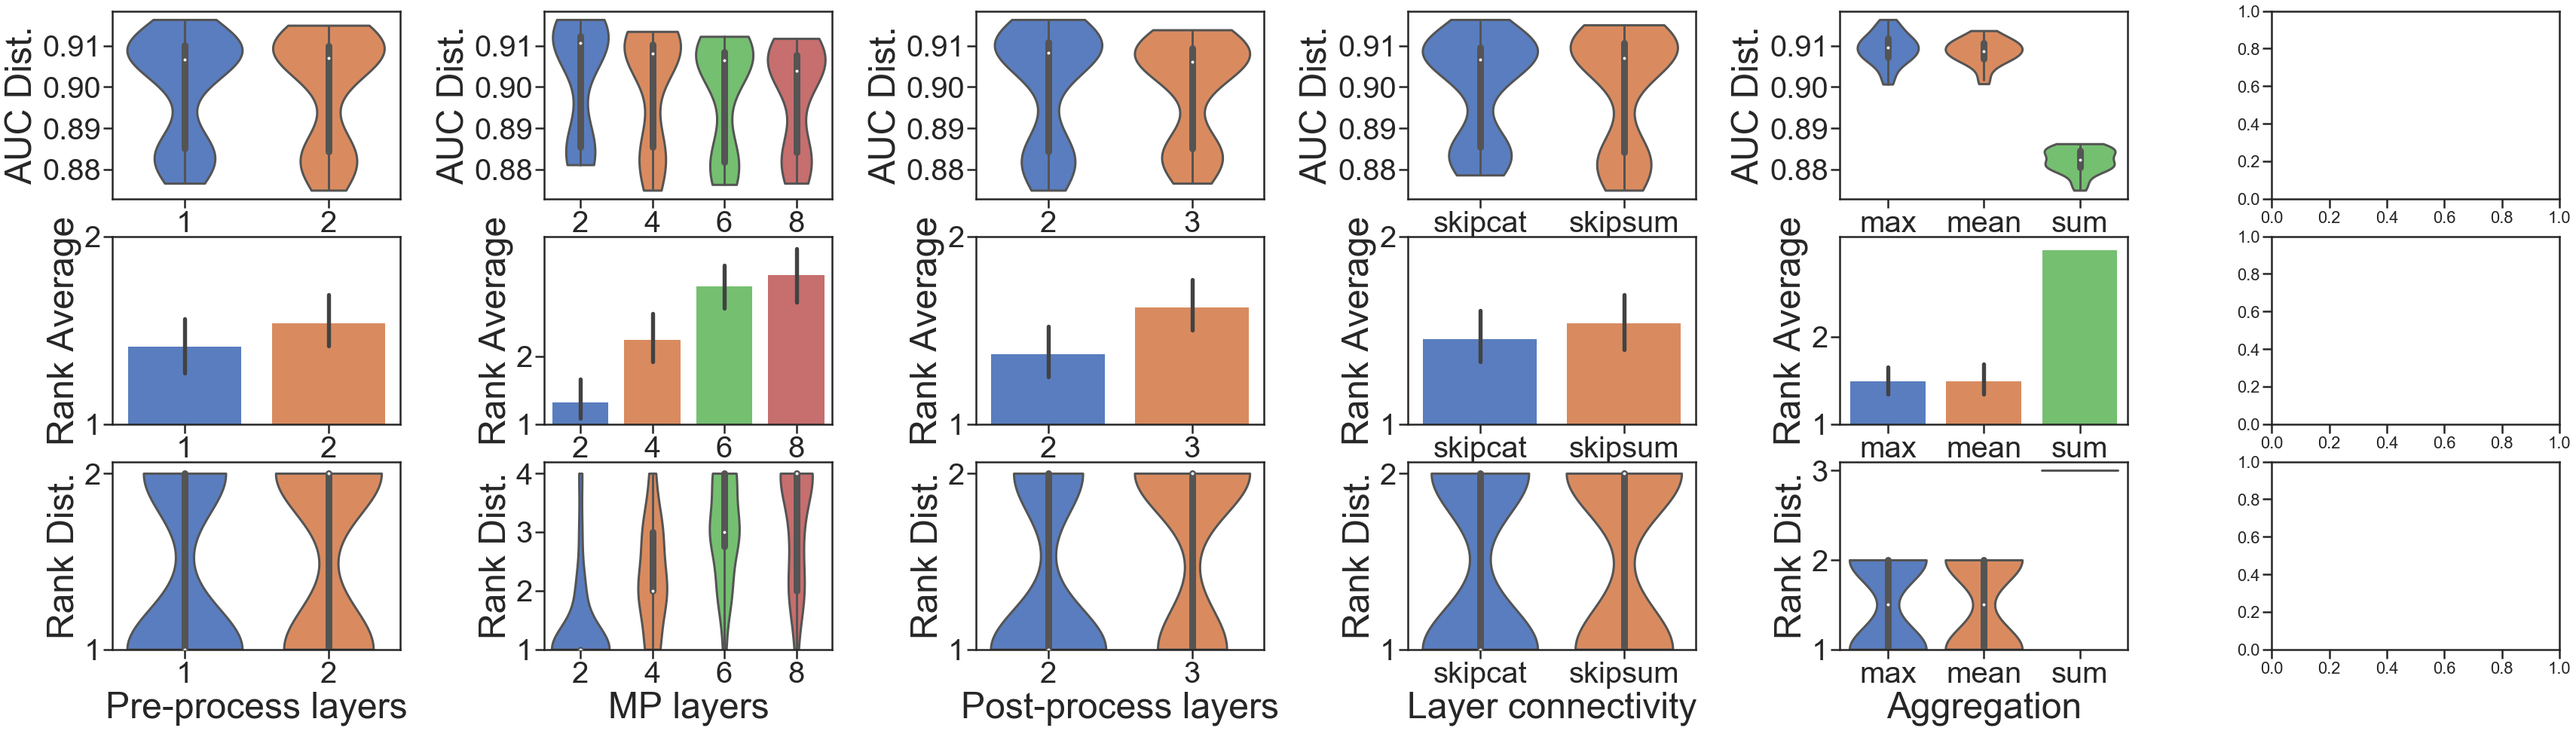

In [2]:
# analysis for a specific dataset (AmazonComputers) over the experiments
experiment_name = 'design_v2_grid_round2'
plot_analysis(experiment_name, division='val', dataset='AmazonComputers', metric='accuracy', rank_resolution=0)

val all [['l_pre', 'l_mp', 'l_post', 'type', 'n']]


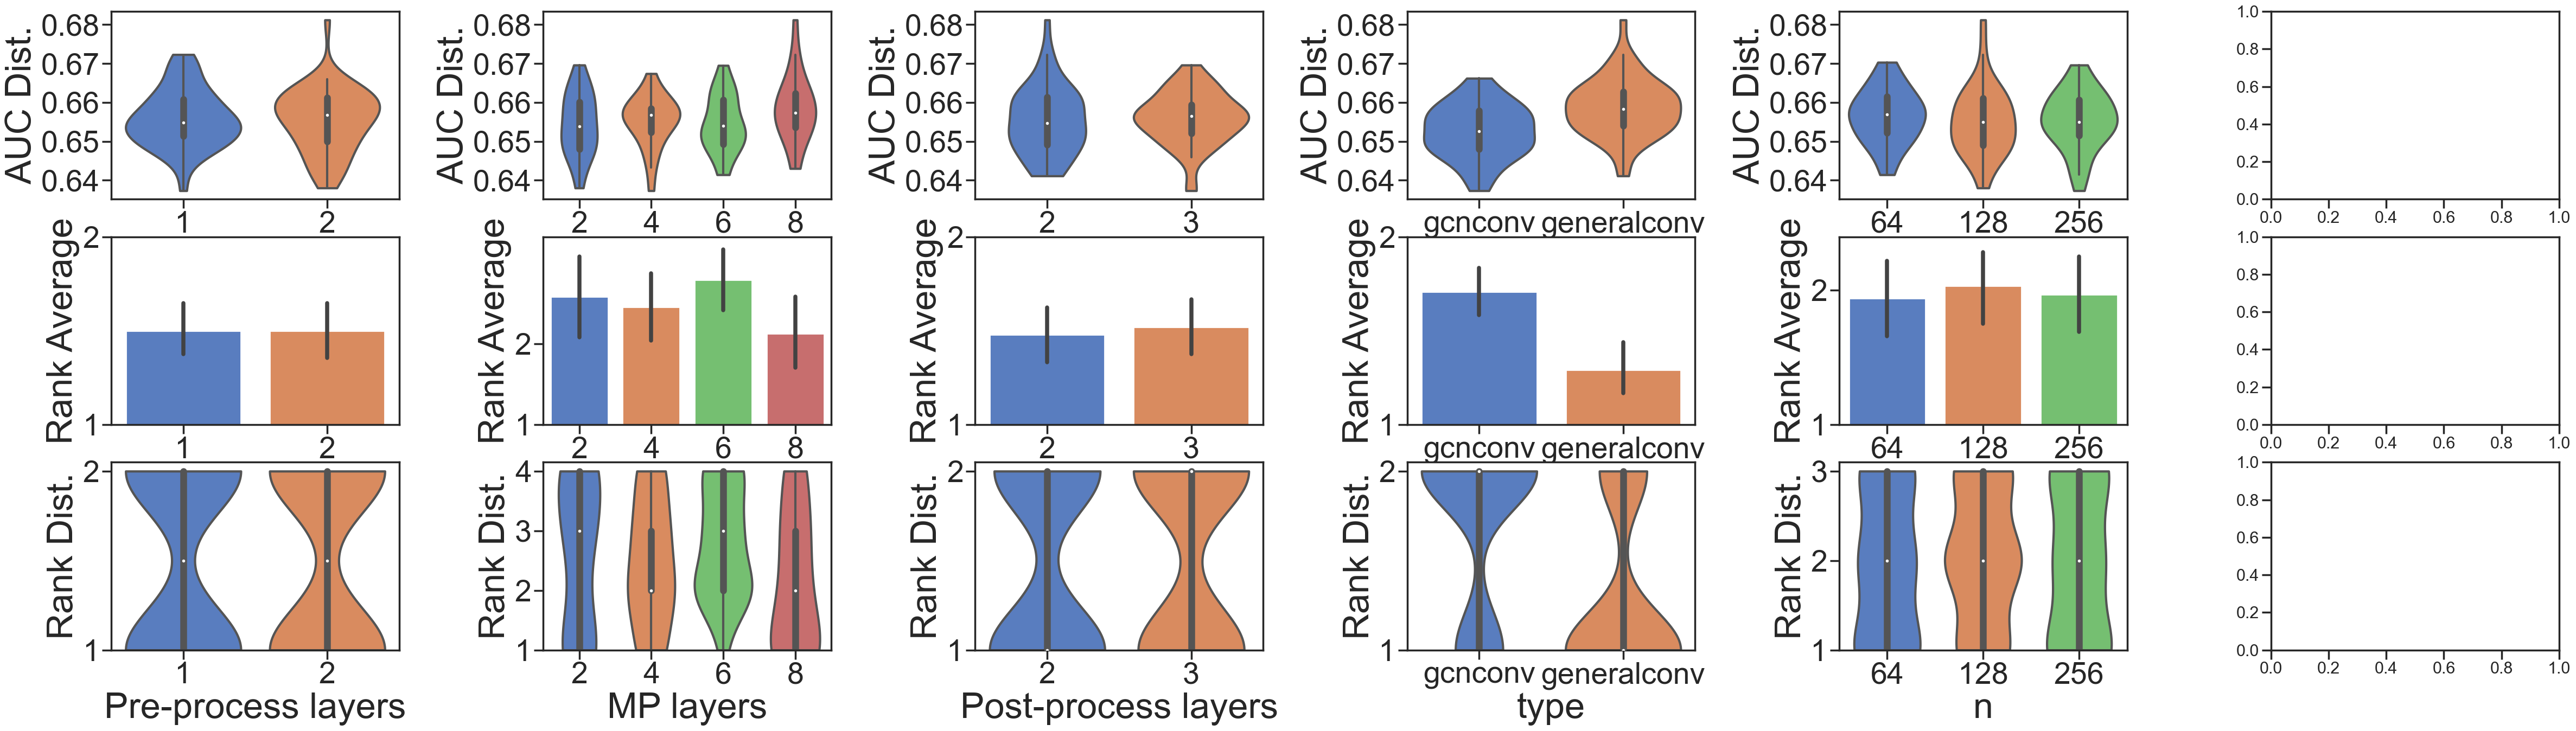

In [2]:
# analysis for all dataset in the batch
experiment_name = 'baseline_graph_grid_first'
plot_analysis(experiment_name, division='val', dataset="all", metric='accuracy', rank_resolution=0)

val None [['l_pre', 'l_mp', 'l_post', 'type', 'n']]
Dataset: TU_DD


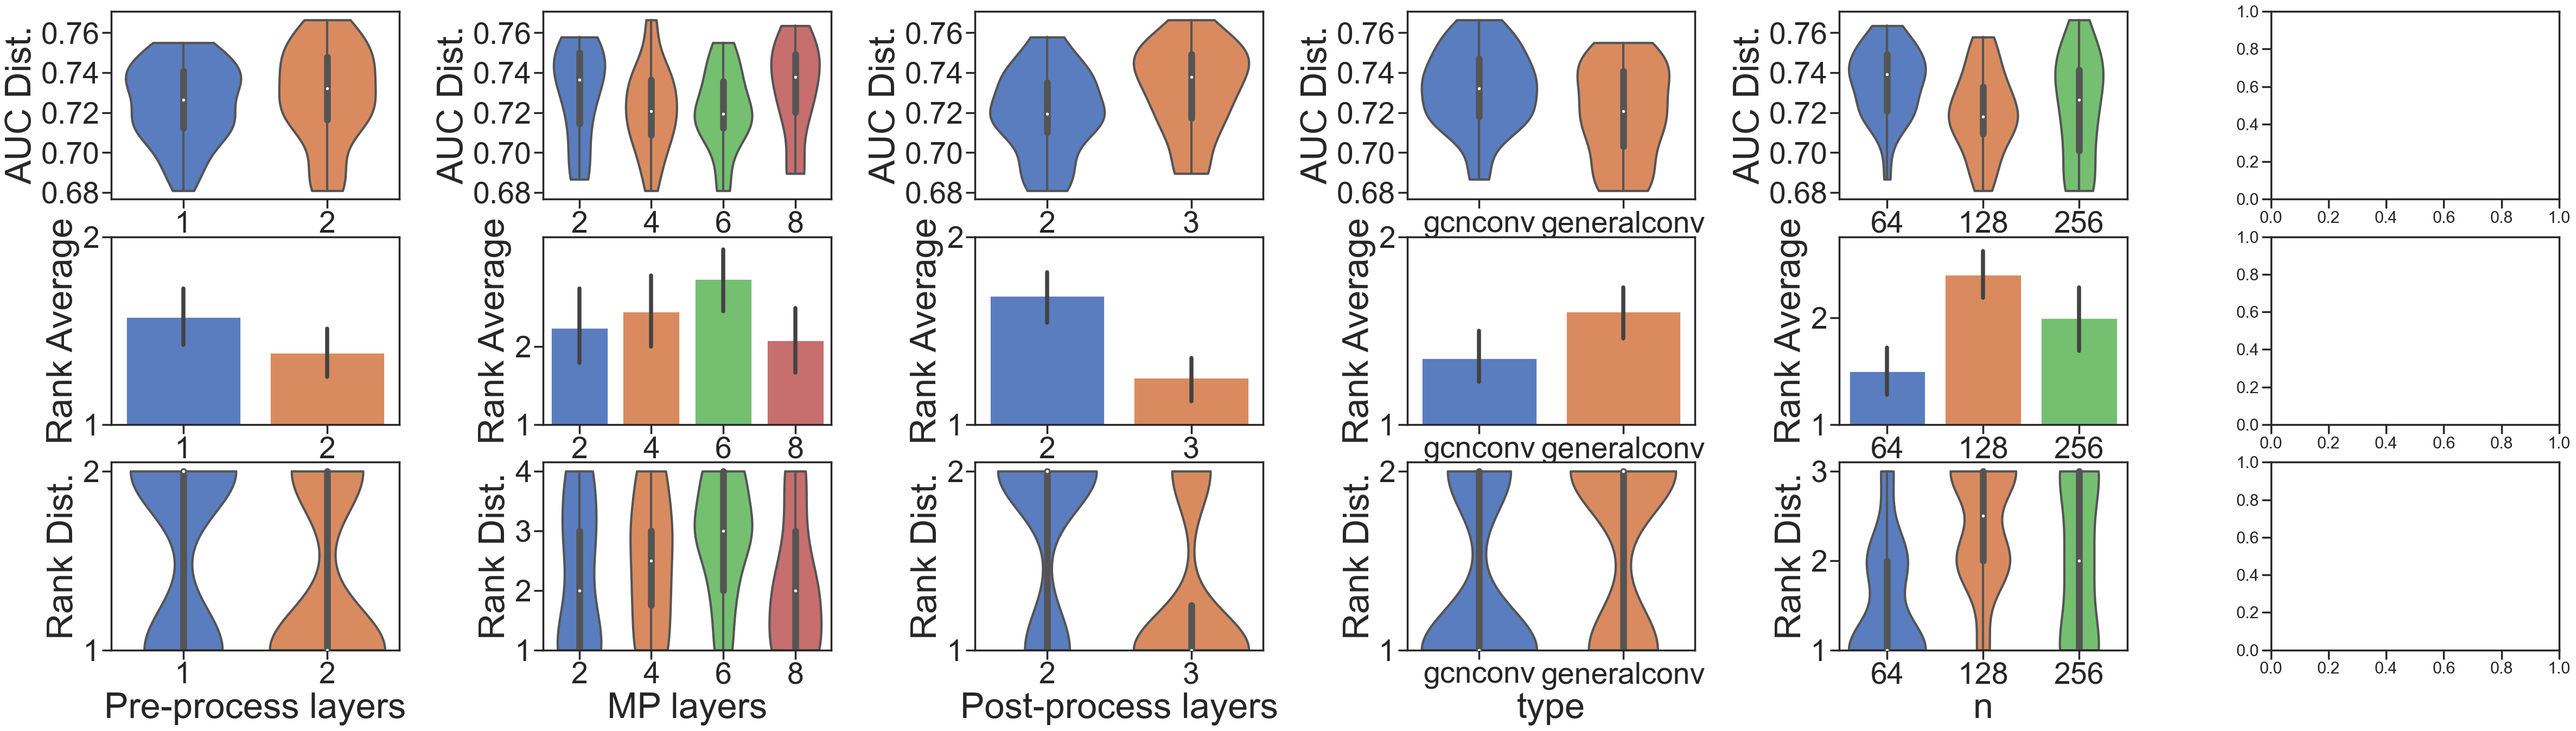

Dataset: TU_ENZYMES


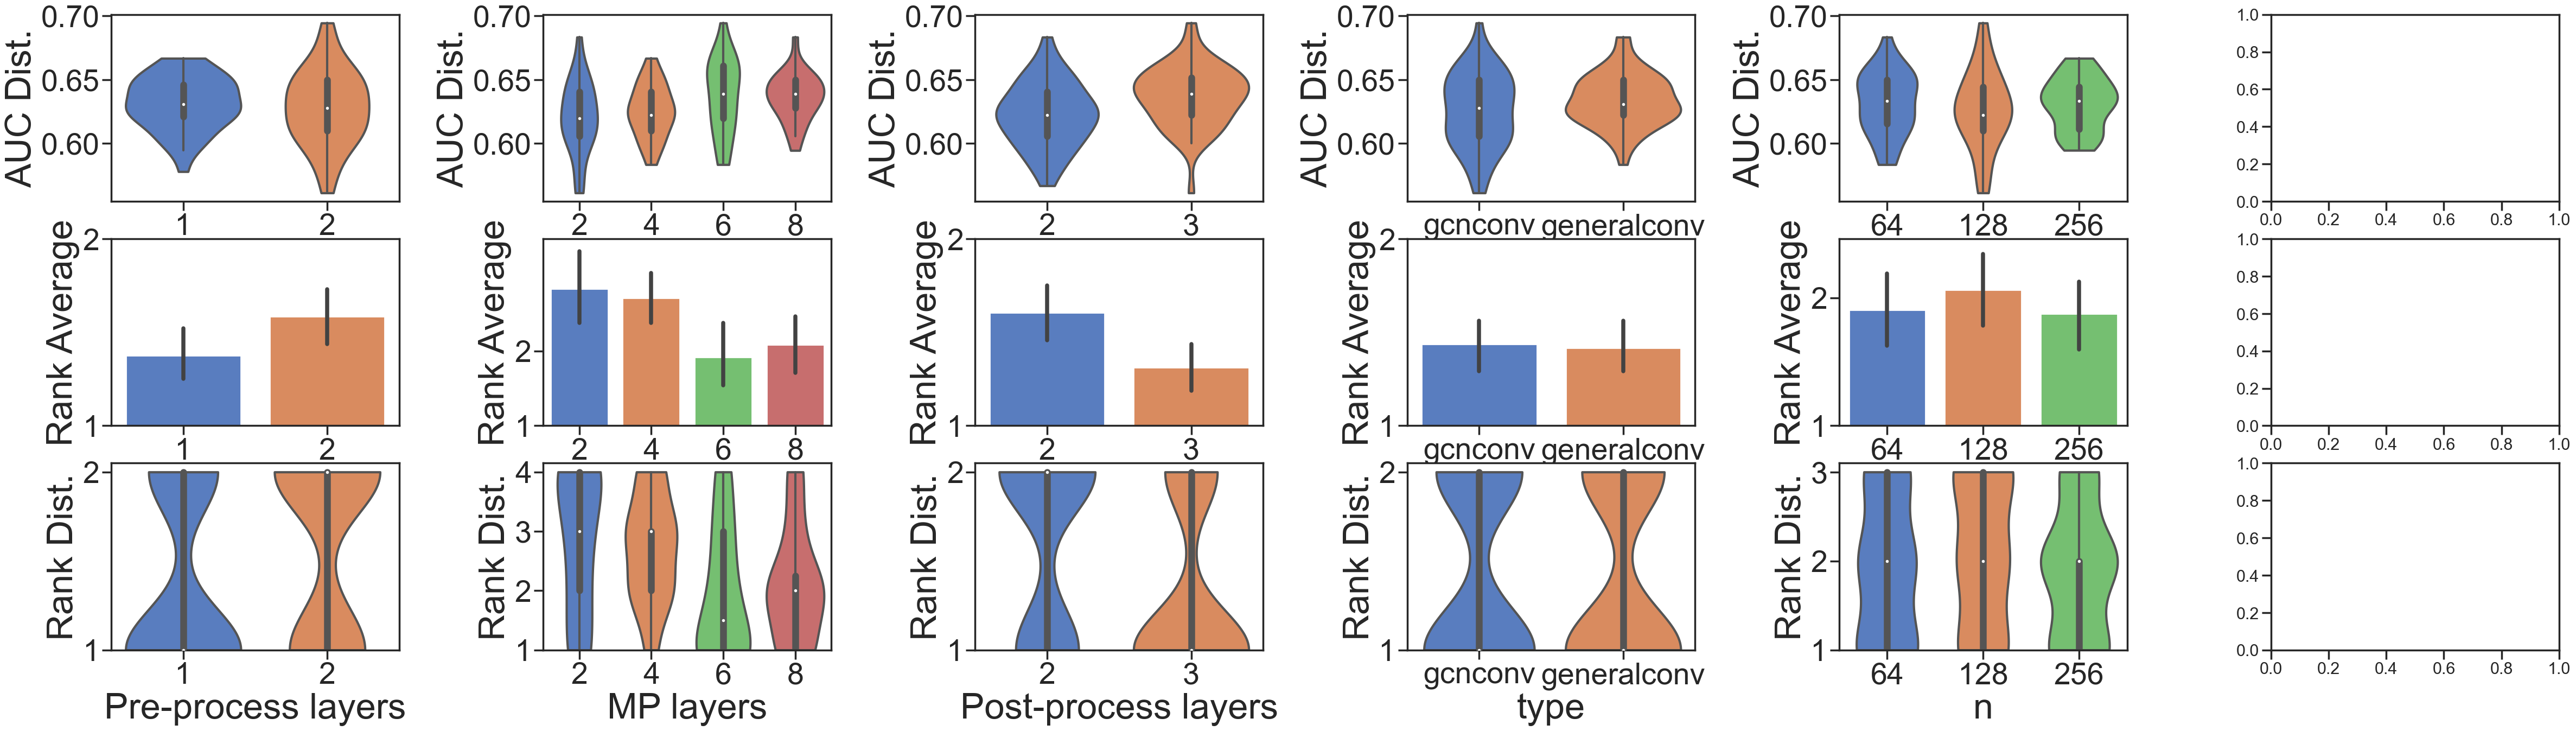

Dataset: TU_IMDB


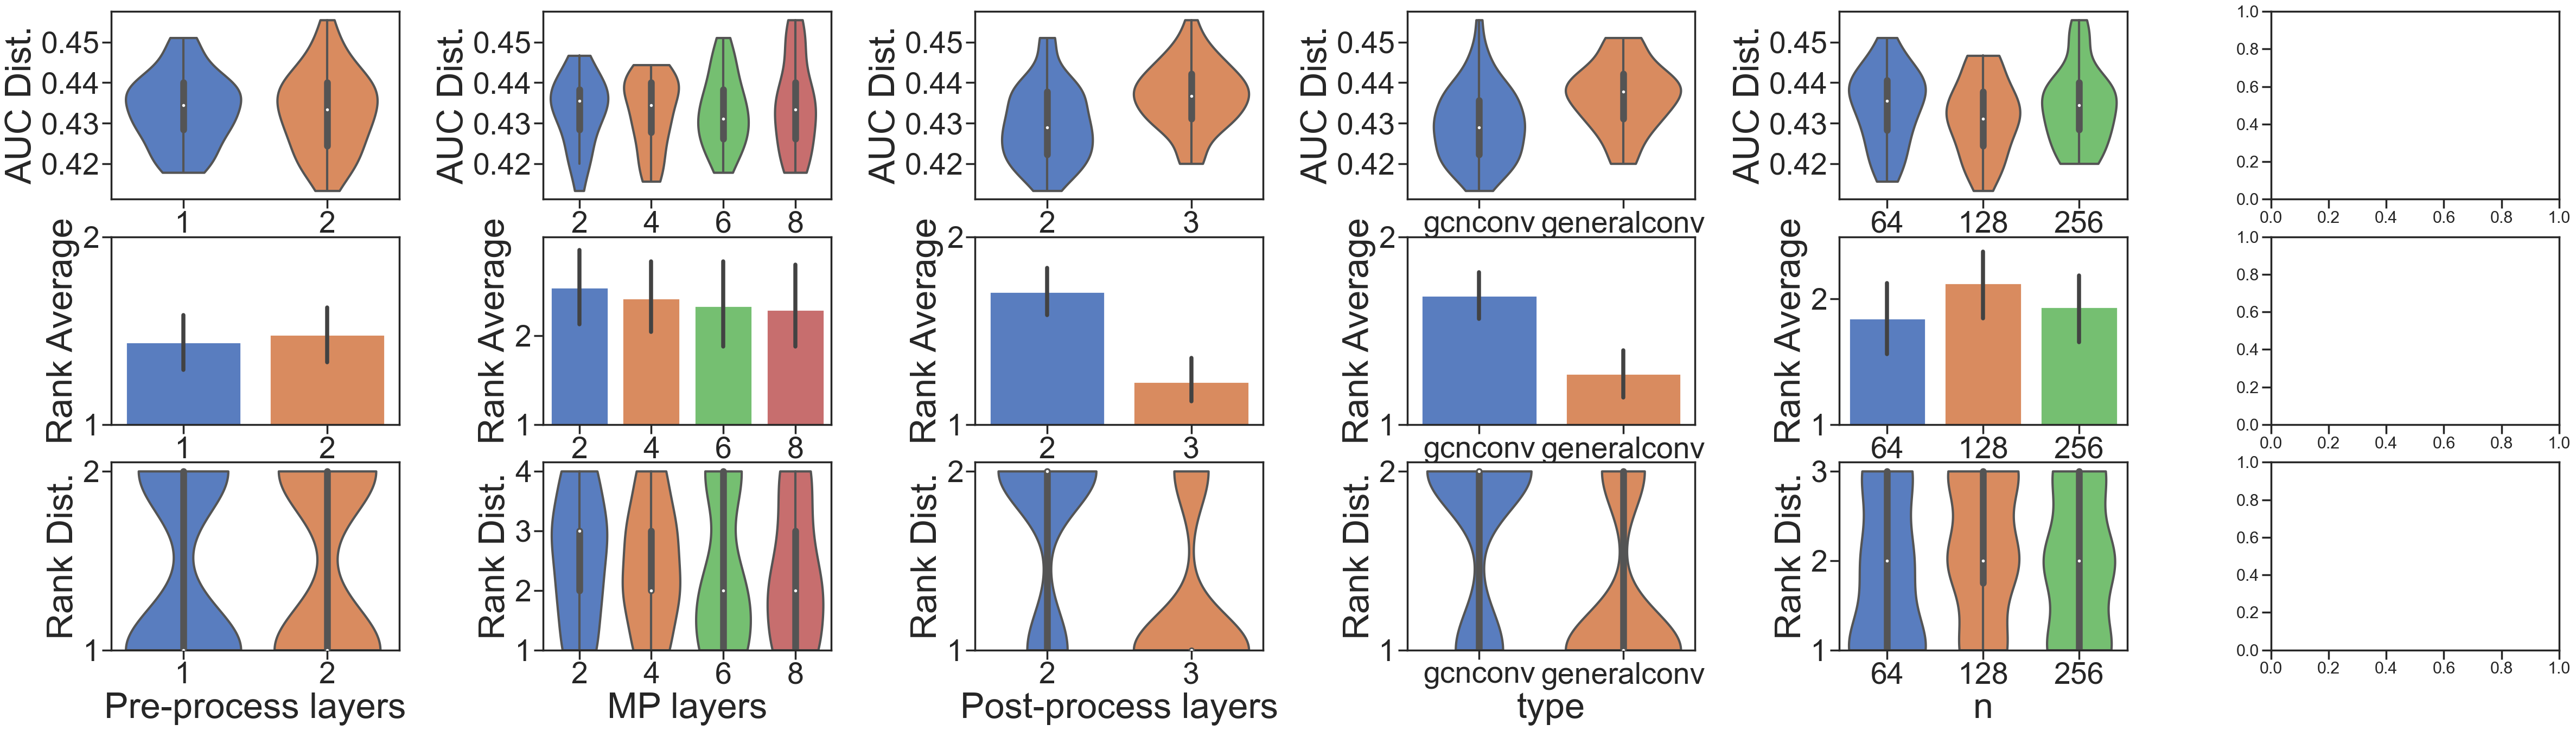

Dataset: TU_NCI1


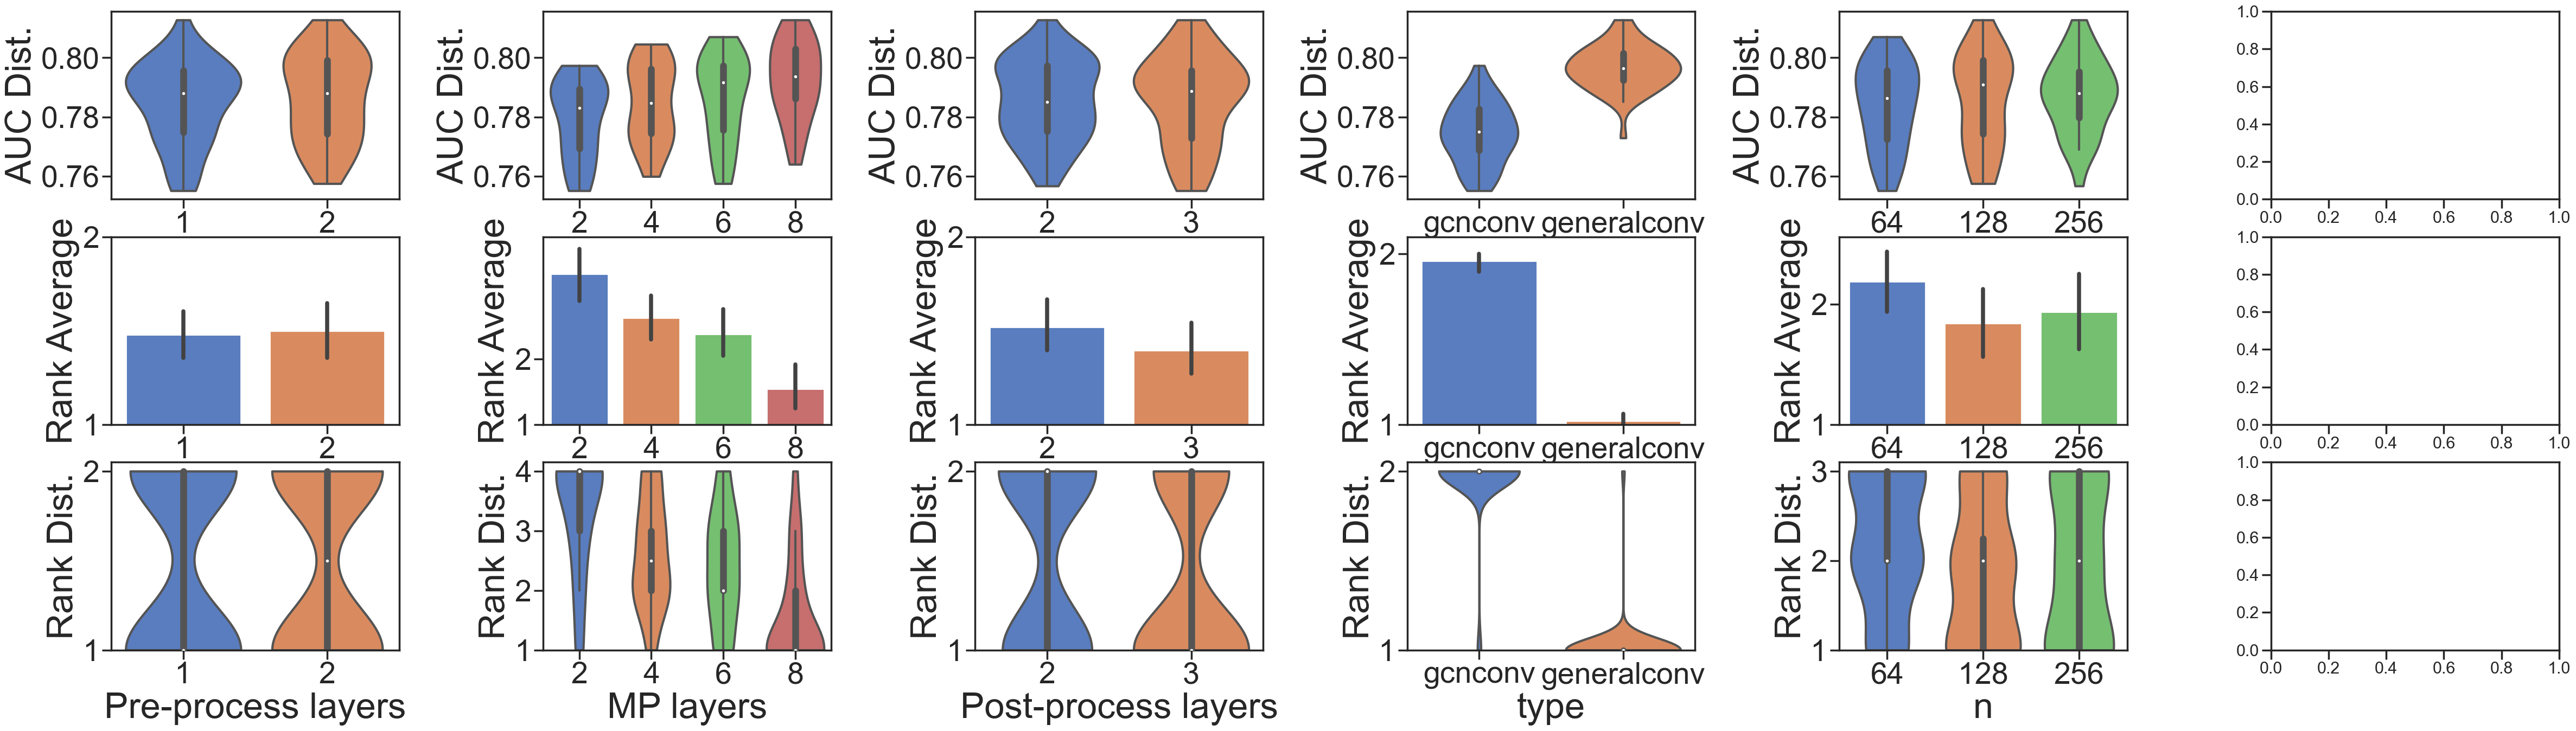

Dataset: TU_PROTEINS


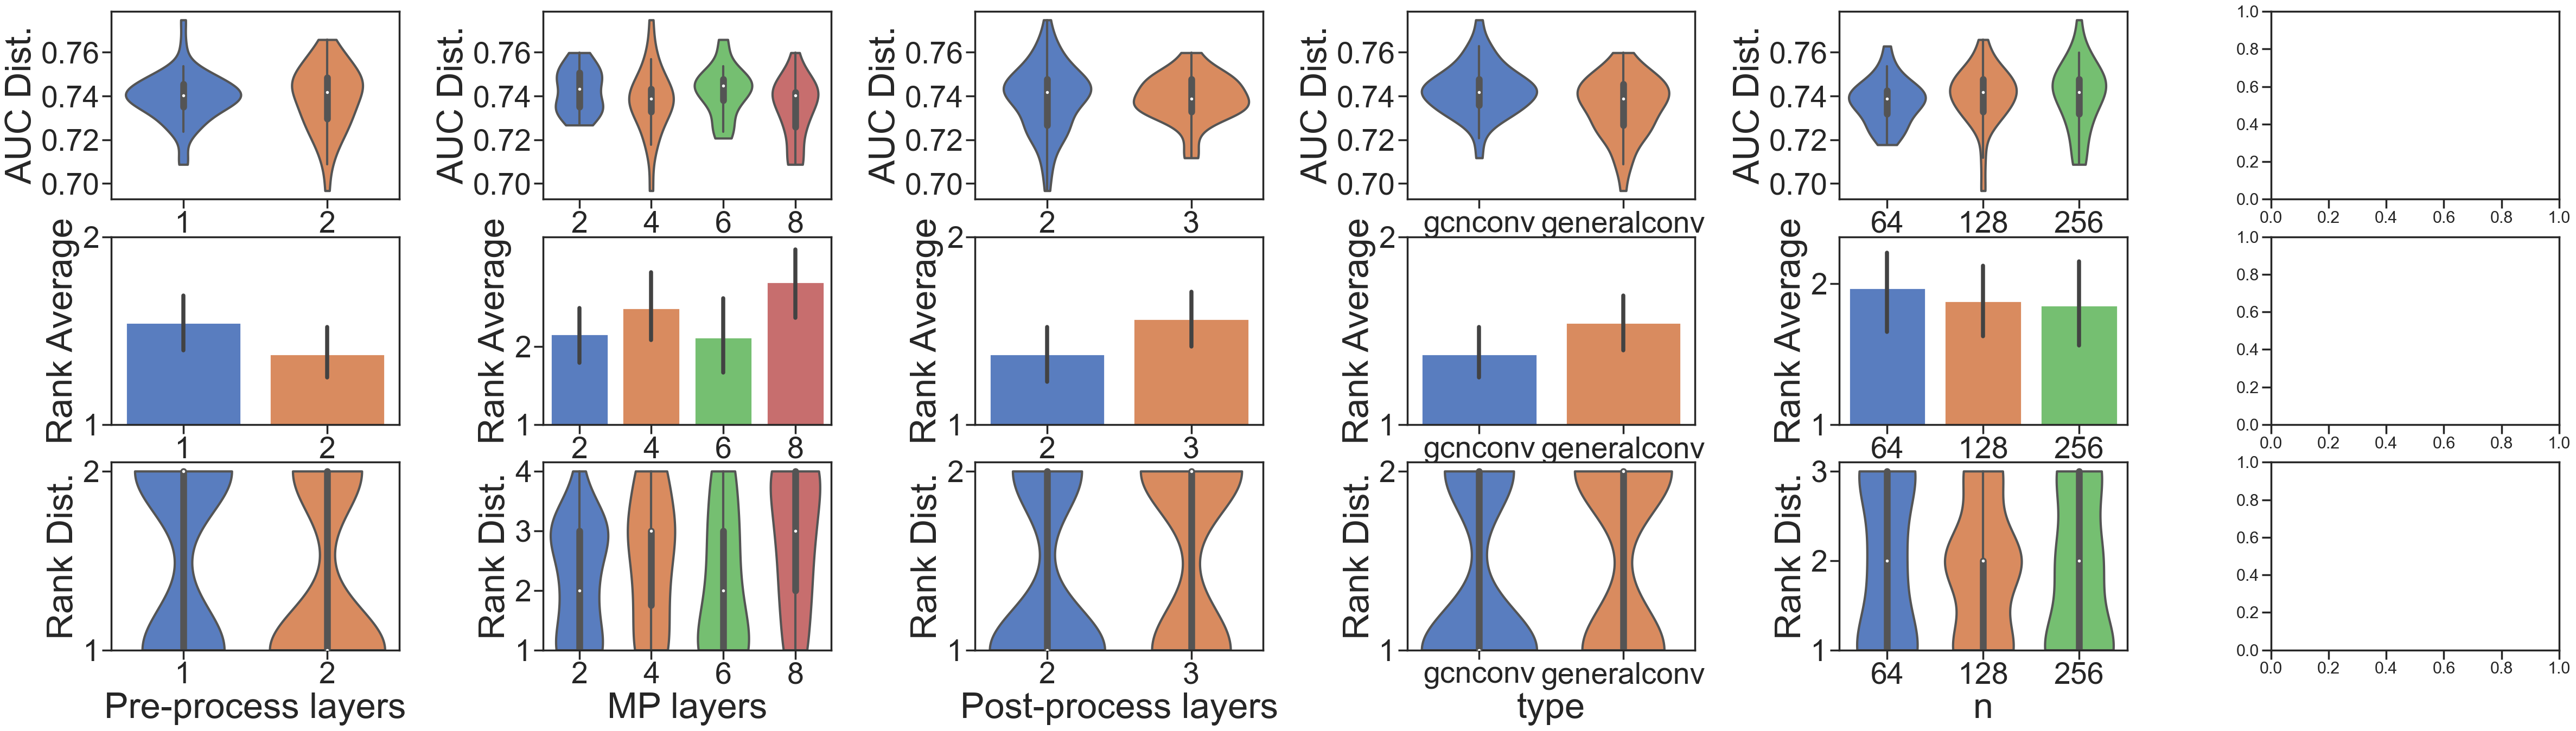

In [5]:
# analysis for each dataset in the batch
experiment_name = 'baseline_graph_grid_first'
plot_analysis(experiment_name, division='val', dataset=None, metric='accuracy', rank_resolution=0)

# Best Accuracy

In [34]:
#Baseline graph
results_file_path = '../run/results/baseline_graph_grid_first/agg/test_best.csv'
df0 = pd.read_csv(results_file_path)
df0 = df0[df0['type']=='gcnconv']
# v1
results_file_path = '../run/results/v1_grid_v1_skipconcat/agg/test_best.csv'
df1 = pd.read_csv(results_file_path)
df = pd.concat([df0, df1], ignore_index=True)
# v2
results_file_path = '../run/results/v2_grid_v2/agg/test_best.csv'
df2 = pd.read_csv(results_file_path)
df = pd.concat([df, df2], ignore_index=True)
# v3
results_file_path = '../run/results/v3_grid_v3/agg/test_best.csv'
df3 = pd.read_csv(results_file_path)
df = pd.concat([df, df3], ignore_index=True)
# v4
results_file_path = '../run/results/v4_grid_v4/agg/test_best.csv'
df4 = pd.read_csv(results_file_path)
df = pd.concat([df, df4], ignore_index=True)
# GraphConv
results_file_path = '../run/results/baseline_graph_grid_graphconv/agg/test_best.csv'
df5 = pd.read_csv(results_file_path)
df = pd.concat([df, df5], ignore_index=True)
# COLLAB
results_file_path = '../run/results/baseline_graph_grid_collab/agg/test_best.csv'
df6 = pd.read_csv(results_file_path)
df = pd.concat([df, df6], ignore_index=True)
# GAT
results_file_path = '../run/results/baseline_graph_grid_GATConv/agg/test_best.csv'
df7 = pd.read_csv(results_file_path)
df = pd.concat([df, df7], ignore_index=True)

df['epoch'] += 1
val_mapping = {'skipconcat': 'skipcat', 'TU_BZR': 'BZR', 'TU_COX2': 'COX2', 'TU_DD': 'DD','dataset':    'Dataset', 'TU_ENZYMES': 'ENZYMES', 'TU_IMDB': 'IMDB', 'TU_PROTEINS': 'PROTEINS', 'TU_IMDB_B': 'IMDB-B', 'TU_PTC_MR': 'PTC', 'TU_COLLAB': 'COLLAB', 'graphconv': 'GraphConv', 'gcnconv': 'GCNconv',
               'graph_path_len': 'path', 'node_clustering_coefficient': 'clustering', 'node_const': 'const', 'GATConv': 'GAT',
               'node_onehot': 'onehot', 'node_pagerank': 'pagerank', 'node': 'Node-level', 'graph': 'Graph-level',
               'l_mp': 'MP layers', 'l_pre': 'Pre-process layers', 'l_post': 'Post-process layers', 'type' : 'GNN Type', 'n': 'Hidden Neurons',
               'stage': 'Layer connectivity', 'lr': 'Learning rate', 'batch': 'Batch size', 'optim': 'Optimizer', 'params': 'Params',
               'epoch': 'Training epochs', 'direct': 'Direction', 'head': 'Multi-task heads', 'l_final': 'Att final',
               'l_type': 'layer_type', 'l_finalbn': 'Final BN', 'task': 'Task', 'subgraph': 'subgraph',
               'margin': 'margin', 'order': 'order', 'norm': 'norm'}

for key, val in val_mapping.items():
    df.replace(key, val, inplace=True)
df.rename(columns=val_mapping, inplace=True)
#df = df.fillna('N/A')
#df.to_excel("./df0.xlsx")
display(df)

Dataset  Pre-process layers  MP layers  Post-process layers GNN Type   
0         DD                   1          2                    2  GCNconv  \
1         DD                   1          2                    2  GCNconv   
2         DD                   1          2                    2  GCNconv   
3         DD                   1          2                    3  GCNconv   
4         DD                   1          2                    3  GCNconv   
...      ...                 ...        ...                  ...      ...   
2663     PTC                   2          8                    2      GAT   
2664     PTC                   2          8                    2      GAT   
2665     PTC                   2          8                    3      GAT   
2666     PTC                   2          8                    3      GAT   
2667     PTC                   2          8                    3      GAT   

      Hidden Neurons  Training epochs    loss  loss_std      Params   
0                 64              200  0.7405    0.1876    351874.0  \
1                128              105  0.9547    0.3884   1391874.0   
2                256              145  0.6910    0.1273   5536258.0   
3                 64               45  0.6901    0.1600    684802.0   
4                128               30  0.5709    0.0392   2721282.0   
...              ...              ...     ...       ...         ...   
2663             128               55  0.9201    0.1885  12568450.0   
2664             256               40  0.8711    0.0863  50237186.0   
2665              64               25  0.7127    0.0129   6136130.0   
2666             128              340  1.0744    0.4557  24519298.0   
2667             256               25  0.8149    0.0287  98026754.0   

      time_iter  time_iter_std  accuracy  accuracy_std  precision   
0        0.0464         0.0103    0.7283        0.0210     0.7442  \
1        0.0411         0.0014    0.6891        0.0238     0.8809   
2        0.0381         0.0031    0.7199        0.0277     0.8053   
3        0.0968         0.0220    0.7451        0.0158     0.8058   
4        0.0692         0.0062    0.7199        0.0286     0.7430   
...         ...            ...       ...           ...        ...   
2663     0.0199         0.0017    0.5809        0.0819     0.4336   
2664     0.0189         0.0001    0.5238        0.0943     0.4119   
2665     0.0222         0.0034    0.5810        0.0486     0.4544   
2666     0.0200         0.0011    0.6095        0.0485     0.4437   
2667     0.0192         0.0001    0.5048        0.0971     0.4486   

      precision_std  recall  recall_std      f1  f1_std     auc  auc_std  
0            0.0349  0.6753      0.1192  0.6995  0.0468  0.8057   0.0225  
1            0.0558  0.4152      0.0845  0.5557  0.0675  0.8299   0.0458  
2            0.0702  0.5703      0.1247  0.6543  0.0597  0.8151   0.0234  
3            0.0701  0.6390      0.1108  0.7006  0.0505  0.8309   0.0042  
4            0.0509  0.6635      0.1570  0.6840  0.0758  0.8286   0.0292  
...             ...     ...         ...     ...     ...     ...      ...  
2663         0.0441  0.4991      0.3063  0.4316  0.1444  0.5992   0.0685  
2664         0.2593  0.4838      0.3376  0.4082  0.2308  0.5719   0.1505  
2665         0.1062  0.4044      0.0360  0.4167  0.0381  0.6463   0.0438  
2666         0.1381  0.5629      0.2519  0.4906  0.1811  0.6194   0.1017  
2667         0.1387  0.6913      0.1715  0.5033  0.0589  0.5926   0.0669  

[2668 rows x 22 columns]

In [35]:
task_names = ['GNN Type','Dataset']

model_names = ['Pre-process layers', 'MP layers', 'Post-process layers','Hidden Neurons','Params','accuracy_std']

df_pivot = pd.pivot_table(df, values='accuracy', index=model_names, columns=task_names, aggfunc=np.mean)
df_pivot

GNN Type                                                                                    GAT   
Dataset                                                                                  COLLAB   
Pre-process layers MP layers Post-process layers Hidden Neurons Params      accuracy_std          
1                  2         2                   64             346242.0    0.0499          NaN  \
                                                                346370.0    0.0485          NaN   
                                                                346626.0    0.0419          NaN   
                                                                346754.0    0.0253          NaN   
                                                                347330.0    0.0750          NaN   
...                                                                                         ...   
2                  8         3                   256            102746114.0 0.0295          NaN   
                                                                102750724.0 0.0227          NaN   
                                                                            0.0266          NaN   
                                                                102759426.0 0.0277          NaN   
                                                                102771975.0 0.0360          NaN   

GNN Type                                                                                       
Dataset                                                                                   DD   
Pre-process layers MP layers Post-process layers Hidden Neurons Params      accuracy_std       
1                  2         2                   64             346242.0    0.0499       NaN  \
                                                                346370.0    0.0485       NaN   
                                                                346626.0    0.0419       NaN   
                                                                346754.0    0.0253       NaN   
                                                                347330.0    0.0750       NaN   
...                                                                                       ..   
2                  8         3                   256            102746114.0 0.0295       NaN   
                                                                102750724.0 0.0227       NaN   
                                                                            0.0266       NaN   
                                                                102759426.0 0.0277       NaN   
                                                                102771975.0 0.0360       NaN   

GNN Type                                                                                           
Dataset                                                                                  ENZYMES   
Pre-process layers MP layers Post-process layers Hidden Neurons Params      accuracy_std           
1                  2         2                   64             346242.0    0.0499           NaN  \
                                                                346370.0    0.0485           NaN   
                                                                346626.0    0.0419           NaN   
                                                                346754.0    0.0253           NaN   
                                                                347330.0    0.0750           NaN   
...                                                                                          ...   
2                  8         3                   256            102746114.0 0.0295           NaN   
                                                                102750724.0 0.0227           NaN   
                                                                            0.0266           NaN   
                                                                1027

In [36]:
max_acc = df.groupby(['Dataset', 'GNN Type'])['accuracy'].max()
max_acc

Dataset   GNN Type 
COLLAB    GAT          0.5567
          GCNconv      0.7940
          GraphConv    0.7587
          MIGNNv1      0.7687
          MIGNNv2      0.7587
          MIGNNv3      0.5647
          MIGNNv4      0.7447
DD        GAT          0.7759
          GCNconv      0.7759
          GraphConv    0.7759
          MIGNNv1      0.7955
          MIGNNv2      0.7731
          MIGNNv3      0.7927
          MIGNNv4      0.7703
ENZYMES   GAT          0.5833
          GCNconv      0.6222
          GraphConv    0.6222
          MIGNNv1      0.6278
          MIGNNv2      0.6334
          MIGNNv3      0.5889
          MIGNNv4      0.6055
IMDB      GAT          0.4000
          GCNconv      0.5045
          GraphConv    0.5089
          MIGNNv1      0.4956
          MIGNNv2      0.4978
          MIGNNv3      0.4934
          MIGNNv4      0.5133
IMDB-B    GAT          0.5567
          GCNconv      0.7167
          GraphConv    0.7300
          MIGNNv1      0.7400
          MIGNNv2   

In [37]:
df_best = df_pivot.max(axis=0).copy().to_frame('Best Performance')
df_id = df_pivot.idxmax(axis=0).to_frame('Best Design (' + "".join(model_names) + ')' )
df_concat = pd.concat([df_best, df_id], axis=1)
print('Best performance in each task')
df_concat

Best performance in each task


Best Performance   
GNN Type  Dataset                      
GAT       COLLAB              0.5567  \
          DD                  0.7759   
          ENZYMES             0.5833   
          IMDB                0.4000   
          IMDB-B              0.5567   
          PROTEINS            0.7411   
          PTC                 0.6667   
          TU_NCI1             0.8021   
GCNconv   COLLAB              0.7940   
          DD                  0.7759   
          ENZYMES             0.6222   
          IMDB                0.5045   
          IMDB-B              0.7167   
          PROTEINS            0.7381   
          PTC                 0.6762   
          TU_NCI1             0.8062   
GraphConv COLLAB              0.7587   
          DD                  0.7759   
          ENZYMES             0.6222   
          IMDB                0.5089   
          IMDB-B              0.7300   
          PROTEINS            0.7500   
          PTC                 0.6952   
          TU_NCI1             0.8167   
MIGNNv1   COLLAB              0.7687   
          DD                  0.7955   
          ENZYMES             0.6278   
          IMDB                0.4956   
          IMDB-B              0.7400   
          PROTEINS            0.7530   
          PTC                 0.6572   
          TU_NCI1             0.8127   
MIGNNv2   COLLAB              0.7587   
          DD                  0.7731   
          ENZYMES             0.6334   
          IMDB                0.4978   
          IMDB-B              0.7367   
          PROTEINS            0.7589   
          PTC                 0.6572   
          TU_NCI1             0.8078   
MIGNNv3   COLLAB              0.5647   
          DD                  0.7927   
          ENZYMES             0.5889   
          IMDB                0.4934   
          IMDB-B              0.7267   
          PROTEINS            0.7381   
          PTC                 0.6476   
          TU_NCI1             0.8062   
MIGNNv4   COLLAB              0.7447   
          DD                  0.7703   
          ENZYMES             0.6055   
          IMDB                0.5133   
          IMDB-B              0.7400   
          PROTEINS            0.7441   
          PTC                 0.6667   
          TU_NCI1             0.7827   

                   Best Design (Pre-process layersMP layersPost-process layersHidden NeuronsParamsaccuracy_std)  
GNN Type  Dataset                                                                                                
GAT       COLLAB                    (1, 2, 2, 128, 1383684.0, 0.0137)                                            
          DD                        (2, 2, 3, 128, 2738690.0, 0.0198)                                            
          ENZYMES                     (1, 8, 3, 64, 6139591.0, 0.036)                                            
          IMDB                       (1, 6, 2, 64, 1901188.0, 0.0218)                                            
          IMDB-B                      (2, 2, 3, 64, 683778.0, 0.0249)                                            
          PROTEINS                 (1, 6, 3, 256, 59214850.0, 0.0263)                                            
          PTC                        (1, 6, 2, 64, 1899586.0, 0.0539)                                            
          TU_NCI1                      (2, 8, 3, 64, 6137346.0, 0.02)                                            
GCNconv   COLLAB                    (1, 4, 2, 128, 3861252.0, 0.0157)                                            
          DD                        (2, 6, 2, 128, 7607298.0, 0.0338)                                            
          ENZYMES                  (2, 8, 3, 128, 24531591.0, 0.0416)                                            
          IMDB                       (1, 8, 3, 64, 6132740.0, 0.0268)                                            
          IMDB-B                   (1, 8, 2, 128, 12546562.0, 0.0531)                                  

In [38]:
task_names = ['Dataset', 'GNN Type']

df_pivot = pd.pivot_table(df, values='accuracy', index=model_names, columns=task_names, aggfunc=np.mean)
df_pivot

Dataset                                                                                  COLLAB   
GNN Type                                                                                    GAT   
Pre-process layers MP layers Post-process layers Hidden Neurons Params      accuracy_std          
1                  2         2                   64             346242.0    0.0499          NaN  \
                                                                346370.0    0.0485          NaN   
                                                                346626.0    0.0419          NaN   
                                                                346754.0    0.0253          NaN   
                                                                347330.0    0.0750          NaN   
...                                                                                         ...   
2                  8         3                   256            102746114.0 0.0295          NaN   
                                                                102750724.0 0.0227          NaN   
                                                                            0.0266          NaN   
                                                                102759426.0 0.0277          NaN   
                                                                102771975.0 0.0360          NaN   

Dataset                                                                                            
GNN Type                                                                                 GCNconv   
Pre-process layers MP layers Post-process layers Hidden Neurons Params      accuracy_std           
1                  2         2                   64             346242.0    0.0499           NaN  \
                                                                346370.0    0.0485           NaN   
                                                                346626.0    0.0419           NaN   
                                                                346754.0    0.0253           NaN   
                                                                347330.0    0.0750           NaN   
...                                                                                          ...   
2                  8         3                   256            102746114.0 0.0295           NaN   
                                                                102750724.0 0.0227           NaN   
                                                                            0.0266           NaN   
                                                                102759426.0 0.0277           NaN   
                                                                102771975.0 0.0360           NaN   

Dataset                                                                                              
GNN Type                                                                                 GraphConv   
Pre-process layers MP layers Post-process layers Hidden Neurons Params      accuracy_std             
1                  2         2                   64             346242.0    0.0499             NaN  \
                                                                346370.0    0.0485             NaN   
                                                                346626.0    0.0419             NaN   
                                                                346754.0    0.0253             NaN   
                                                                347330.0    0.0750             NaN   
...                                                                                            ...   
2                  8         3                   256            102746114.0 0.0295             NaN   
                                                                102750724.0 0.0227             NaN   
                                                                            0.0266        

In [39]:
df_pivot.columns

MultiIndex([(  'COLLAB',       'GAT'),
            (  'COLLAB',   'GCNconv'),
            (  'COLLAB', 'GraphConv'),
            (  'COLLAB',   'MIGNNv1'),
            (  'COLLAB',   'MIGNNv2'),
            (  'COLLAB',   'MIGNNv3'),
            (  'COLLAB',   'MIGNNv4'),
            (      'DD',       'GAT'),
            (      'DD',   'GCNconv'),
            (      'DD', 'GraphConv'),
            (      'DD',   'MIGNNv1'),
            (      'DD',   'MIGNNv2'),
            (      'DD',   'MIGNNv3'),
            (      'DD',   'MIGNNv4'),
            ( 'ENZYMES',       'GAT'),
            ( 'ENZYMES',   'GCNconv'),
            ( 'ENZYMES', 'GraphConv'),
            ( 'ENZYMES',   'MIGNNv1'),
            ( 'ENZYMES',   'MIGNNv2'),
            ( 'ENZYMES',   'MIGNNv3'),
            ( 'ENZYMES',   'MIGNNv4'),
            (    'IMDB',       'GAT'),
            (    'IMDB',   'GCNconv'),
            (    'IMDB', 'GraphConv'),
            (    'IMDB',   'MIGNNv1'),
            (    'IMDB', 

In [11]:
df_pivot.nlargest(3,'DD')

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [40]:

df_best = df_pivot.max(axis=0).copy().to_frame('Best Performance')
df_id = df_pivot.idxmax(axis=0).to_frame('Best Design (' + "".join(model_names) + ')' )
df_concat = pd.concat([df_best, df_id], axis=1)
print('Best performance in each task')
df_concat

Best performance in each task


Best Performance   
Dataset  GNN Type                      
COLLAB   GAT                  0.5567  \
         GCNconv              0.7940   
         GraphConv            0.7587   
         MIGNNv1              0.7687   
         MIGNNv2              0.7587   
         MIGNNv3              0.5647   
         MIGNNv4              0.7447   
DD       GAT                  0.7759   
         GCNconv              0.7759   
         GraphConv            0.7759   
         MIGNNv1              0.7955   
         MIGNNv2              0.7731   
         MIGNNv3              0.7927   
         MIGNNv4              0.7703   
ENZYMES  GAT                  0.5833   
         GCNconv              0.6222   
         GraphConv            0.6222   
         MIGNNv1              0.6278   
         MIGNNv2              0.6334   
         MIGNNv3              0.5889   
         MIGNNv4              0.6055   
IMDB     GAT                  0.4000   
         GCNconv              0.5045   
         GraphConv            0.5089   
         MIGNNv1              0.4956   
         MIGNNv2              0.4978   
         MIGNNv3              0.4934   
         MIGNNv4              0.5133   
IMDB-B   GAT                  0.5567   
         GCNconv              0.7167   
         GraphConv            0.7300   
         MIGNNv1              0.7400   
         MIGNNv2              0.7367   
         MIGNNv3              0.7267   
         MIGNNv4              0.7400   
PROTEINS GAT                  0.7411   
         GCNconv              0.7381   
         GraphConv            0.7500   
         MIGNNv1              0.7530   
         MIGNNv2              0.7589   
         MIGNNv3              0.7381   
         MIGNNv4              0.7441   
PTC      GAT                  0.6667   
         GCNconv              0.6762   
         GraphConv            0.6952   
         MIGNNv1              0.6572   
         MIGNNv2              0.6572   
         MIGNNv3              0.6476   
         MIGNNv4              0.6667   
TU_NCI1  GAT                  0.8021   
         GCNconv              0.8062   
         GraphConv            0.8167   
         MIGNNv1              0.8127   
         MIGNNv2              0.8078   
         MIGNNv3              0.8062   
         MIGNNv4              0.7827   

                   Best Design (Pre-process layersMP layersPost-process layersHidden NeuronsParamsaccuracy_std)  
Dataset  GNN Type                                                                                                
COLLAB   GAT                        (1, 2, 2, 128, 1383684.0, 0.0137)                                            
         GCNconv                    (1, 4, 2, 128, 3861252.0, 0.0157)                                            
         GraphConv                 (1, 6, 3, 256, 60598276.0, 0.0165)                                            
         MIGNNv1                   (1, 8, 2, 256, 52537860.0, 0.0273)                                            
         MIGNNv2                     (2, 4, 2, 64, 1054468.0, 0.0074)                                            
         MIGNNv3                    (2, 2, 2, 256, 5782020.0, 0.0787)                                            
         MIGNNv4                      (1, 6, 3, 64, 3795844.0, 0.009)                                            
DD       GAT                        (2, 2, 3, 128, 2738690.0, 0.0198)                                            
         GCNconv                    (2, 6, 2, 128, 7607298.0, 0.0338)                                            
         GraphConv                   (2, 4, 3, 64, 1940738.0, 0.0241)                                            
         MIGNNv1                   (1, 6, 2, 256, 31699458.0, 0.0241)                                            
         MIGNNv2                    (2, 4, 2, 128, 4213506.0, 0.0069)                                            
         MIGNNv3                     (2, 6, 3, 64, 3803010.0, 0.0352)                                  

In [41]:
df_concat.to_excel("results2.xlsx")

C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:65: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:65: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:65: 

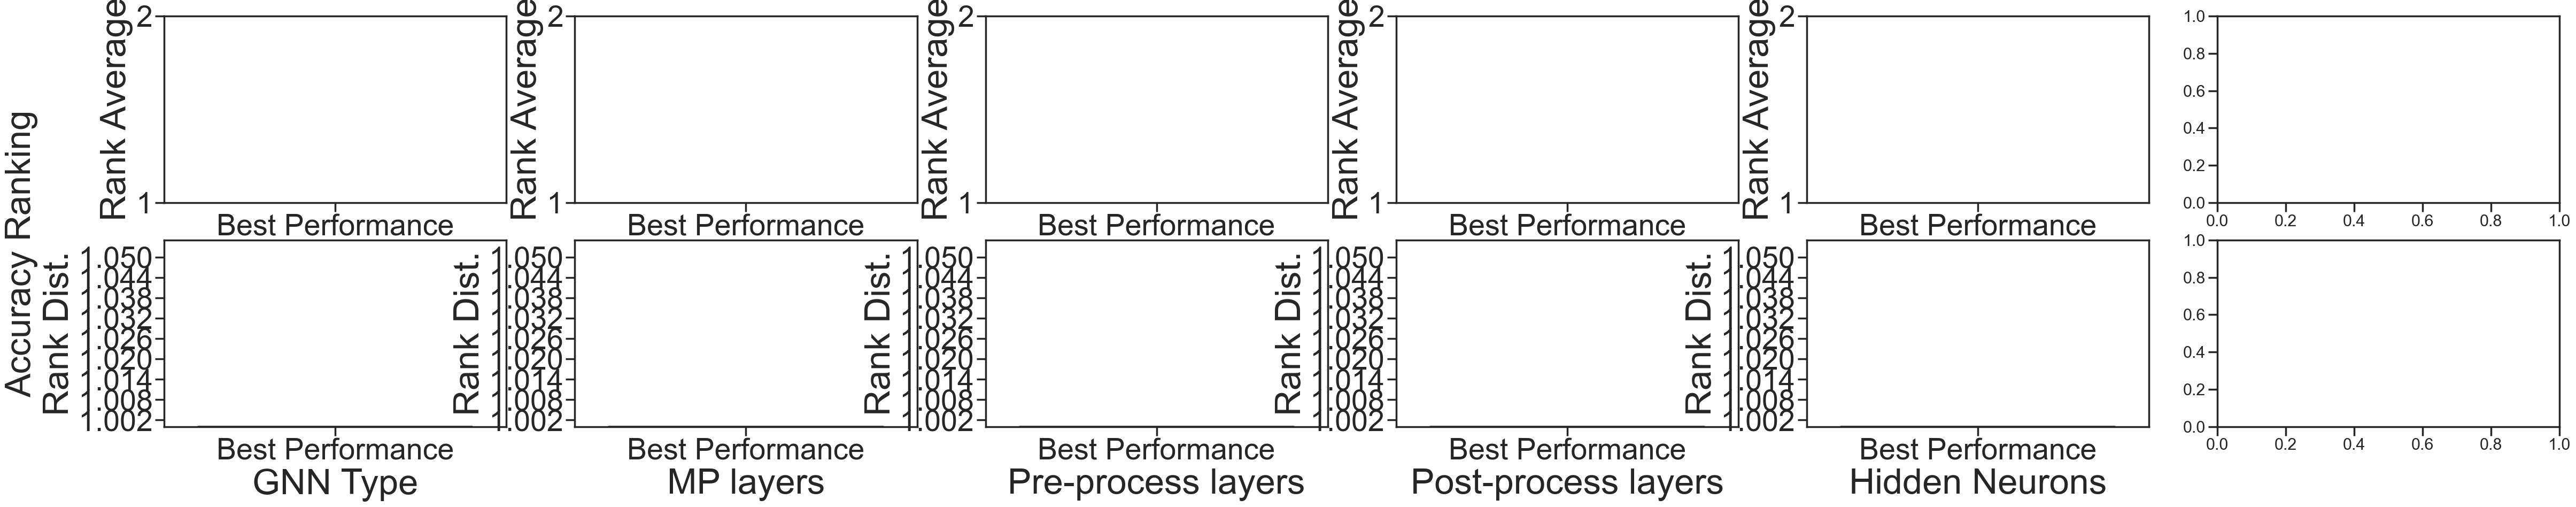

C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:65: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:65: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_32288\3808377546.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)


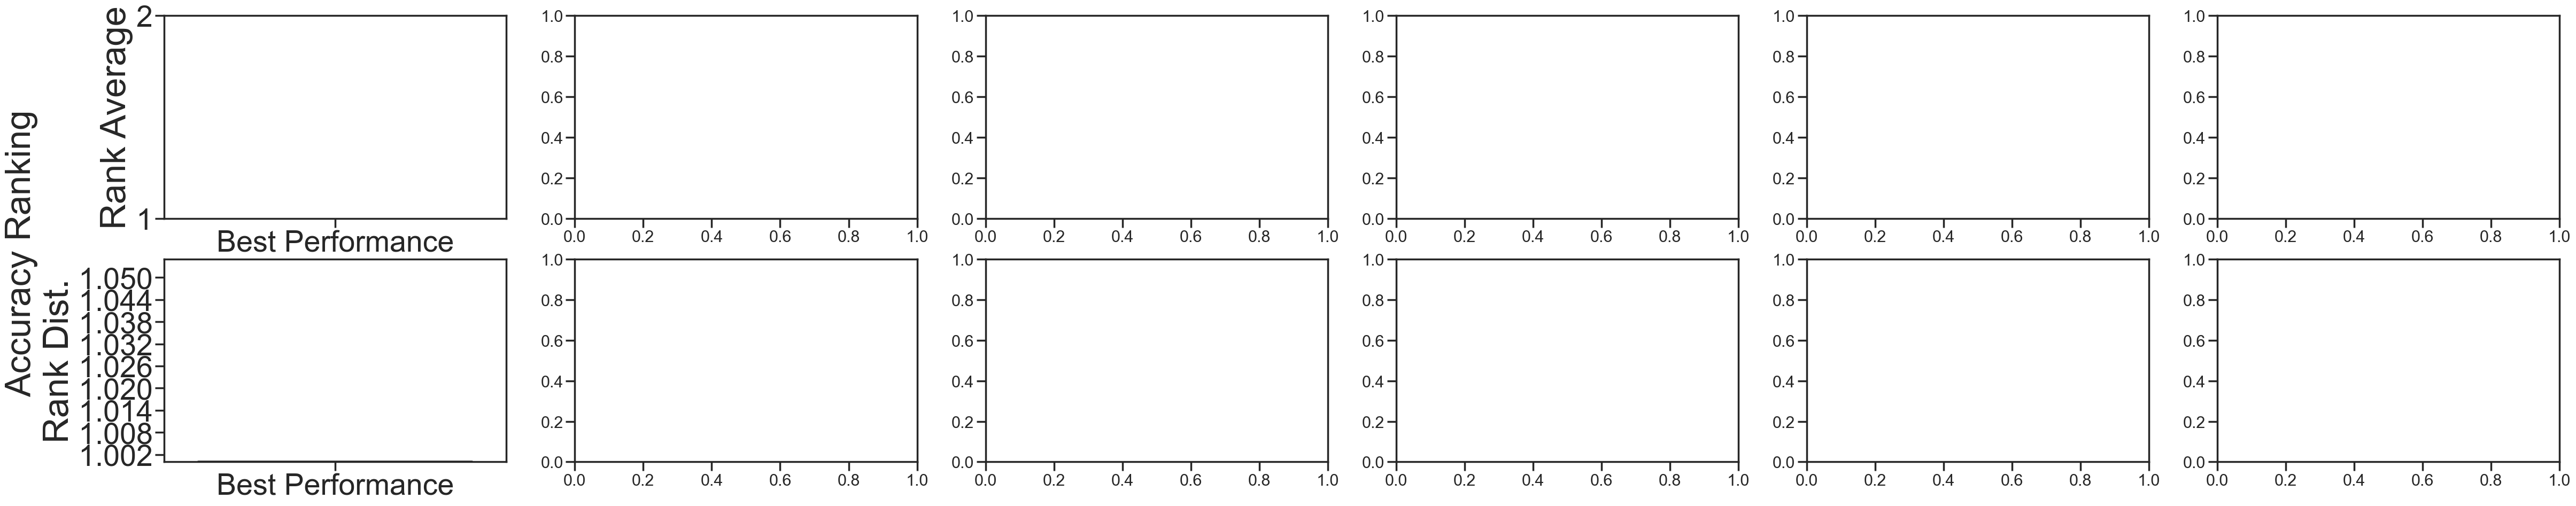

In [28]:
# First Plots
# (1) A general guideline for GNN design
# Trade-off analysis for each design dimension in the design space
# Figure 3 in "Design Space for Graph Neural Networks"
from scipy.stats import rankdata, ttest_ind, f_oneway
from matplotlib.ticker import MaxNLocator

def name_mapping(name):
    # you can add additional name mapping for your customize configurations
    mapping = {}
    if name in mapping:
        return mapping[name]
    else:
        return name

def get_acc(df_pivot, name, ax, plot_type='performance', has_y=True, rank_resolution=0.001, verbose=False):
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(4)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping(name):[]}

    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row
        rank_base = -row
        med = np.median(rank_base)
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= rank_resolution:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping(name)].append(options[j])

    ranks_raw = pd.DataFrame(data=ranks_raw)
    with sns.color_palette("muted"):
        if plot_type=='performance':
            splot = sns.violinplot(x=name_mapping(name), y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('AUC Dist.',fontsize=48)
        elif plot_type=='rank_bar':
            splot = sns.barplot(x=name_mapping(name), y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Rank Average',fontsize=48)
        elif plot_type=='rank_violin':
            sns.violinplot(x=name_mapping(name), y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Rank Dist.',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(40)

for names in [['GNN Type','MP layers','Pre-process layers','Post-process layers','Hidden Neurons'],['']]:
    col = 6
    row = 2
    f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 10))

    for j,metric in enumerate(['rank_bar','rank_violin']):
        for i,name in enumerate(names):
            get_acc(df_best, name, axes[j, i], metric, has_y=True)
    f.text(-0.001, 0.5, 'Accuracy Ranking', ha='center', va='center', rotation='vertical', fontsize=48)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
#     f.savefig('figs/{}.png'.format(metric), dpi=150, bbox_inches='tight')

    plt.show()

C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\339871986.py:63: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\339871986.py:65: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\339871986.py:63: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\339871986.py:65: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)


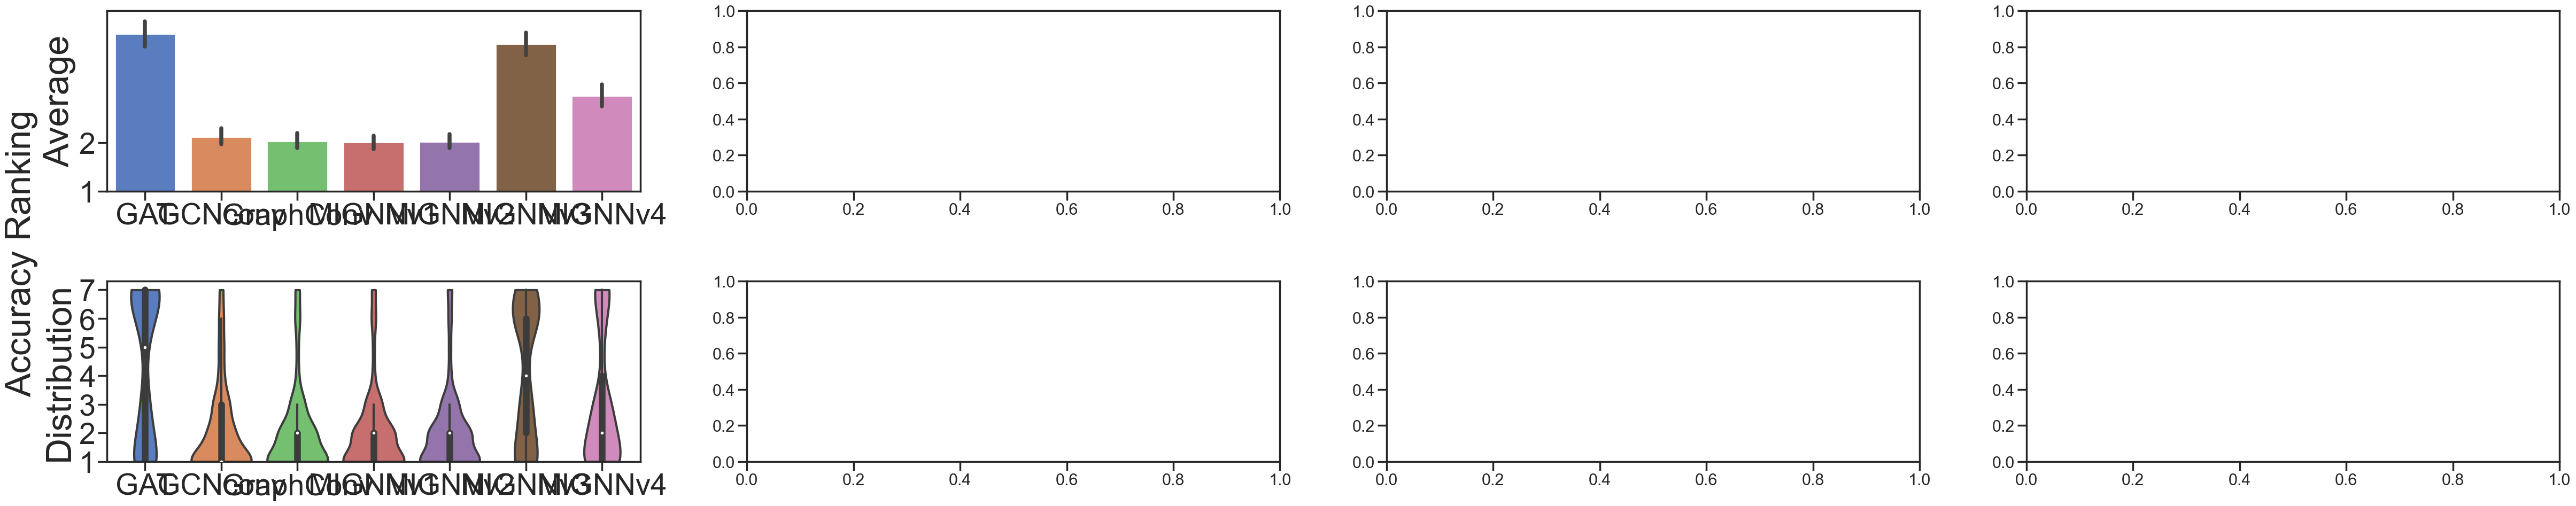

In [42]:
# (6 Appendix) Case study: study new design dimension
# We explore different types of graph attention
# We find that Additive Attention performs the best
# Appendix Figure in "Design Space for Graph Neural Networks"

from scipy.stats import rankdata
from matplotlib.ticker import MaxNLocator

column = ['Dataset', 'Pre-process layers', 'MP layers', 'Post-process layers', 'GNN Type', 'Hidden Neurons']


def get_acc(df, name, ax, metric='acc', has_y=True):
    df_selected = df.copy()

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='accuracy', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(2)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name:[]}

    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.021
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name].append(options[j])

    ranks_raw = pd.DataFrame(data=ranks_raw)
    with sns.color_palette("muted"):
        if metric=='acc':
            splot = sns.violinplot(x=name, y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
        elif metric=='rank_bar':
            splot = sns.barplot(x=name, y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Average',fontsize=48)
        elif metric=='rank_violin':
            sns.violinplot(x=name, y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('',fontsize=48)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Distribution',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(40)


for names in [['GNN Type']]:
    col = 4
    row = 2
    f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 10))


    for j,metric in enumerate(['rank_bar','rank_violin']):
        for i,name in enumerate(names):
            get_acc(df, name, axes[j, i], metric, has_y=i==0)
    f.text(-0.001, 0.5, 'Accuracy Ranking', ha='center', va='center', rotation='vertical', fontsize=48)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

GNN Type 6.340539583164668e-118 True True


C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\2470343801.py:60: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\2470343801.py:62: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\2470343801.py:60: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)
C:\Users\paolo\AppData\Local\Temp\ipykernel_5480\2470343801.py:62: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(40)


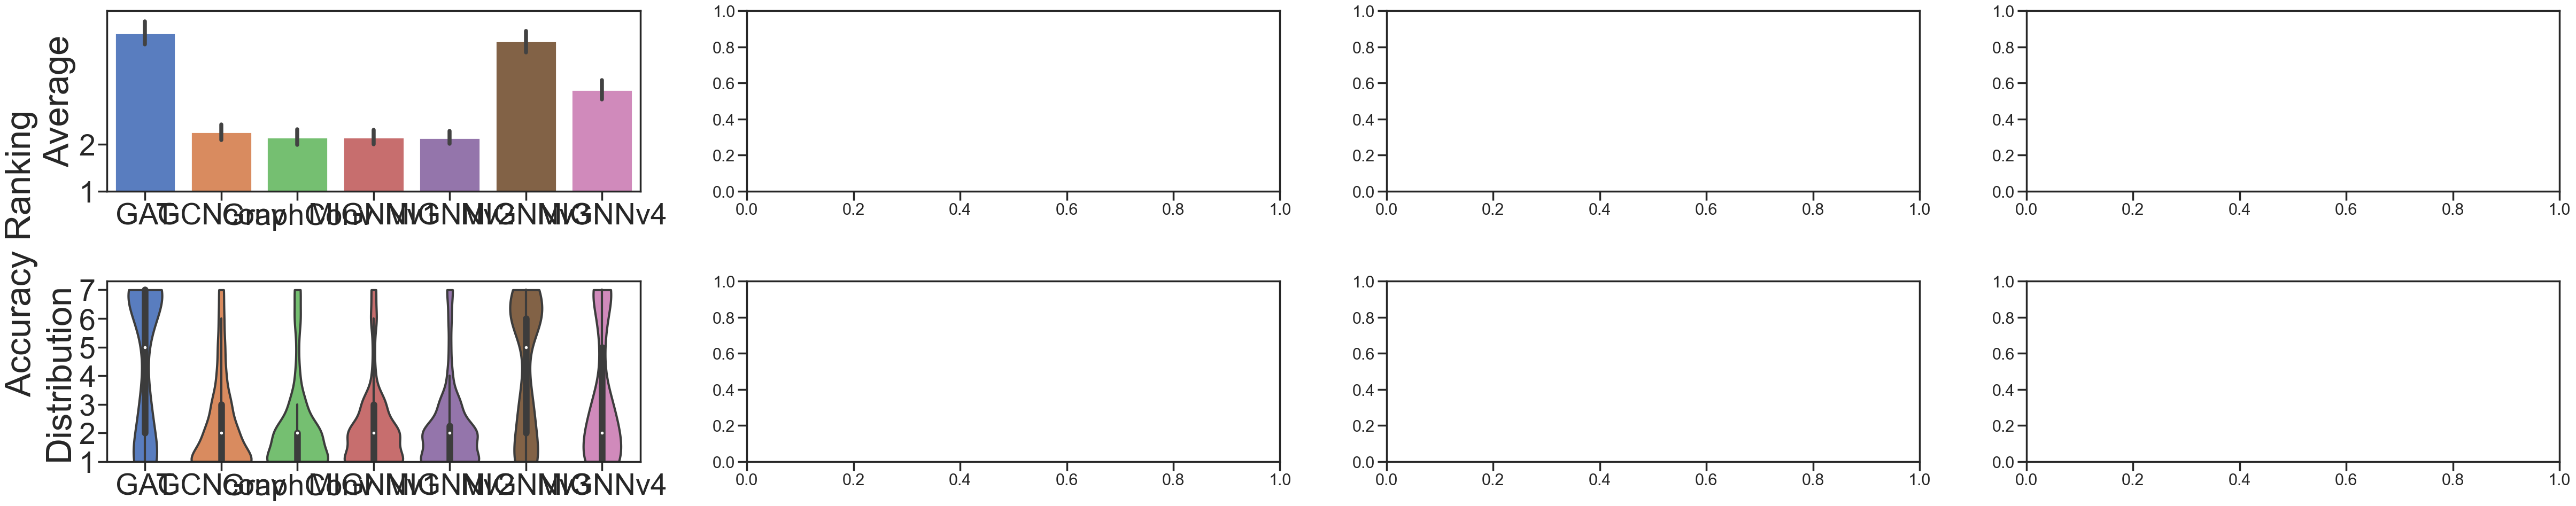

In [43]:
# without rounding and bias
from scipy.stats import rankdata, ttest_ind, f_oneway
def get_acc(df, name, ax, metric='acc', has_y=True):
    df_selected = df.copy()

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='accuracy', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(4)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name:[]}
    rank_np = np.zeros((accs_np.shape[0], accs_np.shape[1]))

    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.021
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name].append(options[j])
            rank_np[i,j]=rank[j]

    if metric == 'rank_bar':
        p_value = f_oneway(*[rank_np[:,i] for i in range(rank_np.shape[1])])[1]
        print(name, p_value, p_value<0.05, p_value<0.05/12)

    ranks_raw = pd.DataFrame(data=ranks_raw)
    with sns.color_palette("muted"):
        if metric=='acc':
            splot = sns.violinplot(x=name, y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
        elif metric=='rank_bar':
            splot = sns.barplot(x=name, y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=48)
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Average',fontsize=48)
        elif metric=='rank_violin':
            sns.violinplot(x=name, y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_xlabel('',fontsize=48)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=48)
            else:
                ax.set_ylabel('Distribution',fontsize=48)
        ax.xaxis.label.set_size(48)
        ax.yaxis.label.set_size(48)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(40)
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(40)


for names in [['GNN Type']]:
    col = 4
    row = 2
    f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 10))


    for j,metric in enumerate(['rank_bar','rank_violin']):
        for i,name in enumerate(names):
            get_acc(df, name, axes[j, i], metric, has_y=i==0)
    f.text(-0.001, 0.5, 'Accuracy Ranking', ha='center', va='center', rotation='vertical', fontsize=48)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

In [52]:
df = df[df['Dataset'] != 'PTC']

In [53]:
    df_selected = df.copy()

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='accuracy', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(4)
    options = df_pivot.columns.values

    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name:[]}
    rank_np = np.zeros((accs_np.shape[0], accs_np.shape[1]))

    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.001
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name].append(options[j])
            rank_np[i,j]=rank[j]

ranks_raw = pd.DataFrame(data=ranks_raw)

In [54]:
import scipy.stats as stats
#https://scikit-posthocs.readthedocs.io/en/latest/tutorial.html
dfr = pd.DataFrame(data=rank_np, columns=options)
stat, p = stats.kruskal(dfr['MIGNNv1'], dfr['MIGNNv2'], dfr['MIGNNv3'], dfr['MIGNNv4'], dfr['GCNconv'],dfr['GraphConv'], dfr['GAT'])
print(p)

1.4516078282424868e-122


In [55]:
ranks_raw

Model ID  Accuracy  Acc. Ranking   GNN Type
0            0    0.5560             6        GAT
1            0    0.7680             1    GCNconv
2            0    0.7253             4  GraphConv
3            0    0.7340             3    MIGNNv1
4            0    0.7373             2    MIGNNv2
...        ...       ...           ...        ...
2347       335    0.7932             2  GraphConv
2348       335    0.7802             3    MIGNNv1
2349       335    0.7697             7    MIGNNv2
2350       335    0.7738             6    MIGNNv3
2351       335    0.7770             5    MIGNNv4

[2352 rows x 4 columns]

                    GAT       GCNconv     GraphConv       MIGNNv1   
GAT        1.000000e+00  3.854315e-29  2.911849e-51  1.344799e-45  \
GCNconv    3.854315e-29  1.000000e+00  3.687055e-04  8.974731e-03   
GraphConv  2.911849e-51  3.687055e-04  1.000000e+00  7.099865e-01   
MIGNNv1    1.344799e-45  8.974731e-03  7.099865e-01  1.000000e+00   
MIGNNv2    7.856654e-47  5.103077e-03  7.099865e-01  8.298496e-01   
MIGNNv3    1.890943e-01  1.508126e-20  5.279265e-40  6.046978e-35   
MIGNNv4    1.947317e-14  2.358866e-03  3.086068e-13  2.417836e-10   

                MIGNNv2       MIGNNv3       MIGNNv4  
GAT        7.856654e-47  1.890943e-01  1.947317e-14  
GCNconv    5.103077e-03  1.508126e-20  2.358866e-03  
GraphConv  7.099865e-01  5.279265e-40  3.086068e-13  
MIGNNv1    8.298496e-01  6.046978e-35  2.417836e-10  
MIGNNv2    1.000000e+00  4.878628e-36  6.158522e-11  
MIGNNv3    4.878628e-36  1.000000e+00  1.218186e-08  
MIGNNv4    6.158522e-11  1.218186e-08  1.000000e+00  


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x14411b257f0>)

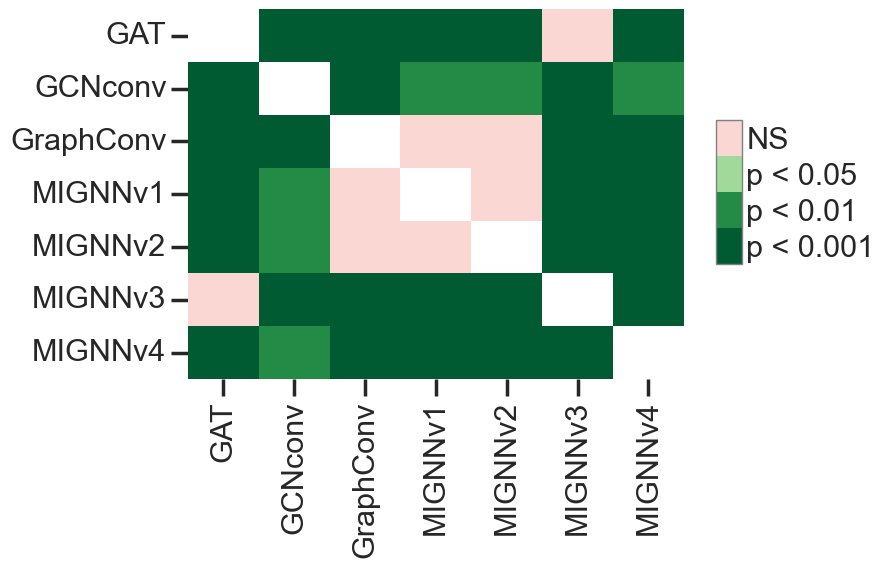

In [56]:
import scikit_posthocs as sp
test_results = sp.posthoc_conover_friedman(
     ranks_raw,
     melted=True,
     block_col='Model ID',
     group_col='GNN Type',
     y_col='Accuracy',
     p_adjust='holm-sidak')
print(test_results)
sp.sign_plot(test_results)

In [57]:
avg_rank = ranks_raw.groupby('Model ID').Accuracy.rank(pct=True).groupby(ranks_raw['GNN Type']).mean()
avg_rank

GNN Type
GAT          0.343963
GCNconv      0.620111
GraphConv    0.717049
MIGNNv1      0.694303
MIGNNv2      0.699405
MIGNNv3      0.390306
MIGNNv4      0.534864
Name: Accuracy, dtype: float64

{'markers': [<matplotlib.collections.PathCollection at 0x14411f3c550>,
 'elbows': [<matplotlib.lines.Line2D at 0x14411f3c280>,
 'labels': [Text(0.3339625850340136, -2, 'GAT (0.34)'),
  Text(0.3339625850340136, -3, 'MIGNNv3 (0.39)'),
  Text(0.3339625850340136, -4, 'MIGNNv4 (0.53)'),
  Text(0.3339625850340136, -5, 'GCNconv (0.62)'),
  Text(0.7270493197278911, -2, '(0.72) GraphConv'),
  Text(0.7270493197278911, -3, '(0.7) MIGNNv2'),
  Text(0.7270493197278911, -4, '(0.69) MIGNNv1')],
 'crossbars': [[<matplotlib.lines.Line2D at 0x14411f1ecd0>],
  [<matplotlib.lines.Line2D at 0x14411f1efa0>]]}

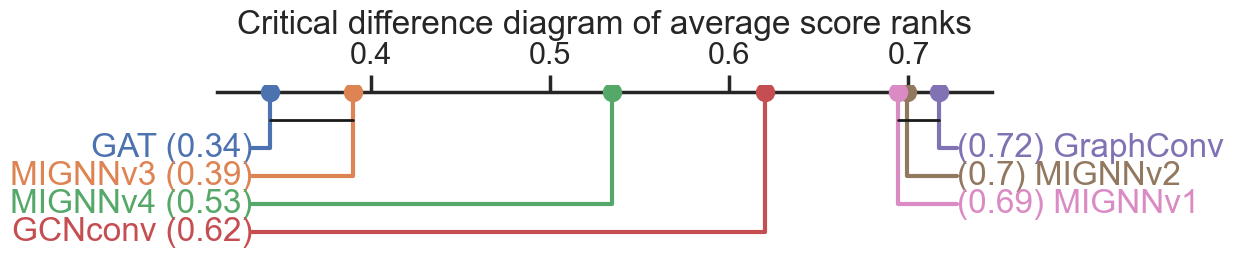

In [58]:
plt.figure(figsize=(10, 2), dpi=100)
plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(avg_rank, test_results)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1440ea6f670>)

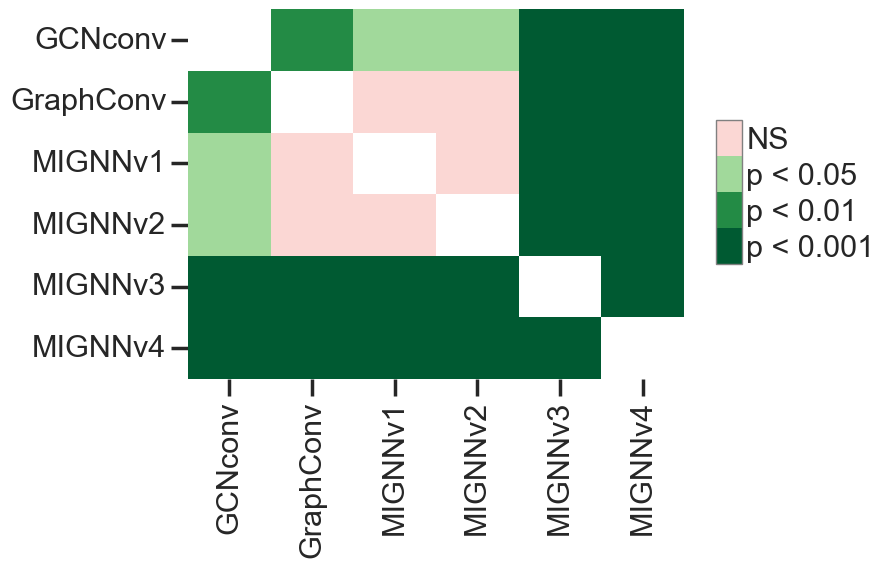

In [27]:
test_results2 = sp.posthoc_siegel_friedman(
     ranks_raw,
     melted=True,
     block_col='Model ID',
     group_col='GNN Type',
     y_col='Accuracy',
     p_adjust='holm' )

sp.sign_plot(test_results2)

{'markers': [<matplotlib.collections.PathCollection at 0x1440ffb3820>,
 'elbows': [<matplotlib.lines.Line2D at 0x1440ffb3550>,
 'labels': [Text(0.3693402777777777, -2, 'MIGNNv3 (0.38)'),
  Text(0.3693402777777777, -3, 'MIGNNv4 (0.51)'),
  Text(0.3693402777777777, -4, 'GCNconv (0.6)'),
  Text(0.6909895833333334, -2, '(0.68) GraphConv'),
  Text(0.6909895833333334, -3, '(0.67) MIGNNv1'),
  Text(0.6909895833333334, -4, '(0.66) MIGNNv2')],
 'crossbars': [[<matplotlib.lines.Line2D at 0x1440ffa7370>]]}

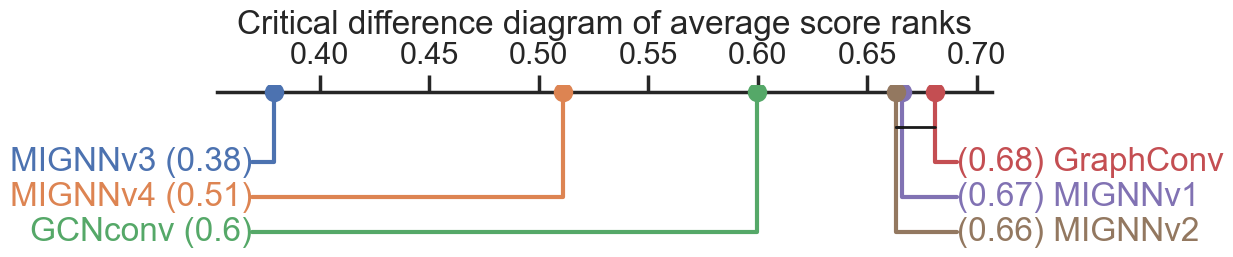

In [28]:
plt.figure(figsize=(10, 2), dpi=100)
plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(avg_rank, test_results2)

In [17]:
test_results.values - test_results2.values

array([[ 0.   , -0.005,  0.   , -0.   , -0.   ],
       [-0.005,  0.   ,  0.   ,  0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   ,  0.   , -0.005],
       [-0.   , -0.   , -0.   , -0.005,  0.   ]])

In [37]:
# Single Dataset with best model
# https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
from scipy.stats import chi2
single_d = max_acc.unstack()
print(single_d)
average_rank_d = single_d.rank(pct = True, axis = 1).mean(axis = 0)
print(average_rank_d)

GNN Type  GCNconv  GraphConv  MIGNNv1  MIGNNv2  MIGNNv3  MIGNNv4
Dataset                                                         
COLLAB     0.7940     0.7587   0.7687   0.7587   0.5647   0.7447
DD         0.7759     0.7759   0.7955   0.7731   0.7927   0.7703
ENZYMES    0.6222     0.6222   0.6278   0.6334   0.5889   0.6055
IMDB       0.5045     0.5089   0.4956   0.4978   0.4934   0.5133
IMDB-B     0.7167     0.7300   0.7400   0.7367   0.7267   0.7400
PROTEINS   0.7381     0.7500   0.7530   0.7589   0.7381   0.7441
PTC        0.6762     0.6952   0.6572   0.6572   0.6476   0.6667
TU_NCI1    0.8062     0.8167   0.8127   0.8078   0.8062   0.7827
GNN Type
GCNconv      0.562500
GraphConv    0.718750
MIGNNv1      0.750000
MIGNNv2      0.645833
MIGNNv3      0.312500
MIGNNv4      0.510417
dtype: float64


In [43]:
single_d.values

array([[0.794, 0.759, 0.769, 0.759, 0.565, 0.745],
       [0.776, 0.776, 0.795, 0.773, 0.793, 0.77 ],
       [0.622, 0.622, 0.628, 0.633, 0.589, 0.606],
       [0.504, 0.509, 0.496, 0.498, 0.493, 0.513],
       [0.717, 0.73 , 0.74 , 0.737, 0.727, 0.74 ],
       [0.738, 0.75 , 0.753, 0.759, 0.738, 0.744],
       [0.676, 0.695, 0.657, 0.657, 0.648, 0.667],
       [0.806, 0.817, 0.813, 0.808, 0.806, 0.783]])

In [47]:
ss.friedmanchisquare(*single_d.values.T)

FriedmanchisquareResult(statistic=10.897435897435898, pvalue=0.05345187924947095)

In [53]:
print(sp.posthoc_conover_friedman(single_d, p_adjust='holm'))
print(sp.posthoc_miller_friedman(single_d))
print(sp.posthoc_siegel_friedman(single_d, p_adjust='holm'))
print(sp.posthoc_nemenyi_friedman(single_d))

           GCNconv  GraphConv   MIGNNv1   MIGNNv2   MIGNNv3  MIGNNv4
GCNconv        1.0   1.000000  1.000000  1.000000  1.000000      1.0
GraphConv      1.0   1.000000  1.000000  1.000000  0.213422      1.0
MIGNNv1        1.0   1.000000  1.000000  1.000000  0.141225      1.0
MIGNNv2        1.0   1.000000  1.000000  1.000000  0.566787      1.0
MIGNNv3        1.0   0.213422  0.141225  0.566787  1.000000      1.0
MIGNNv4        1.0   1.000000  1.000000  1.000000  1.000000      1.0
            GCNconv  GraphConv   MIGNNv1   MIGNNv2   MIGNNv3   MIGNNv4
GCNconv    1.000000   0.962205  0.919168  0.997903  0.765701  0.999787
GraphConv  0.962205   1.000000  0.999983  0.998899  0.236719  0.877929
MIGNNv1    0.919168   0.999983  1.000000  0.993954  0.163261  0.797178
MIGNNv2    0.997903   0.998899  0.993954  1.000000  0.470384  0.979846
MIGNNv3    0.765701   0.236719  0.163261  0.470384  1.000000  0.899842
MIGNNv4    0.999787   0.877929  0.797178  0.979846  0.899842  1.000000
           GCNconv  

In [29]:
data = [single_d.iloc[i, ].values for i in range(single_d.shape[0])]
ss.kruskal(*data)
data = np.array(data)
H, p = ss.friedmanchisquare(*data.T)
# Adjust stat
N = 8
k = 6
F = (N-1)*H/(N*(k-1)-H)
print(F)
print(f"{H=}, {p=}")
print((chi2.sf(H, k-1)))

2.6211453744493394
H=10.897435897435898, p=0.05345187924947095
0.05345187924947095


0.04978297303719621 24


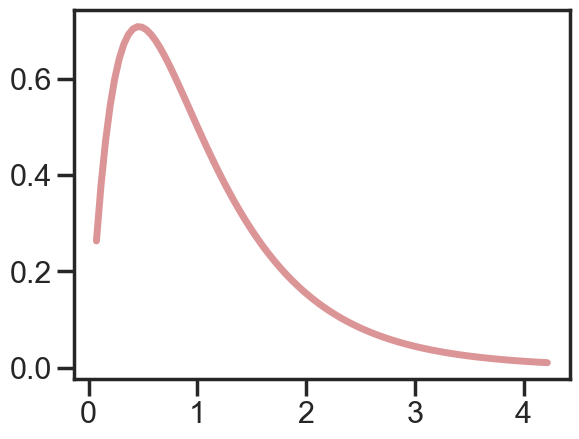

In [48]:
import numpy as np
from scipy.stats import f
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
dfn, dfd = k-1, (k-1)*(N-1)

x = np.linspace(f.ppf(0.01, dfn, dfd),
                f.ppf(0.99, dfn, dfd), 100)
ax.plot(x, f.pdf(x, dfn, dfd),
       'r-', lw=5, alpha=0.6, label='f pdf')
print(f.sf(F, dfn, dfd), dfd)

          0         1         2         3         4         5
0  1.000000  0.900000  0.814349  0.900000  0.582807  0.900000
1  0.900000  1.000000  0.900000  0.900000  0.095645  0.737168
2  0.814349  0.900000  1.000000  0.900000  0.056506  0.621396
3  0.900000  0.900000  0.900000  1.000000  0.267587  0.900000
4  0.582807  0.095645  0.056506  0.267587  1.000000  0.775758
5  0.900000  0.737168  0.621396  0.900000  0.775758  1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1a348592940>)

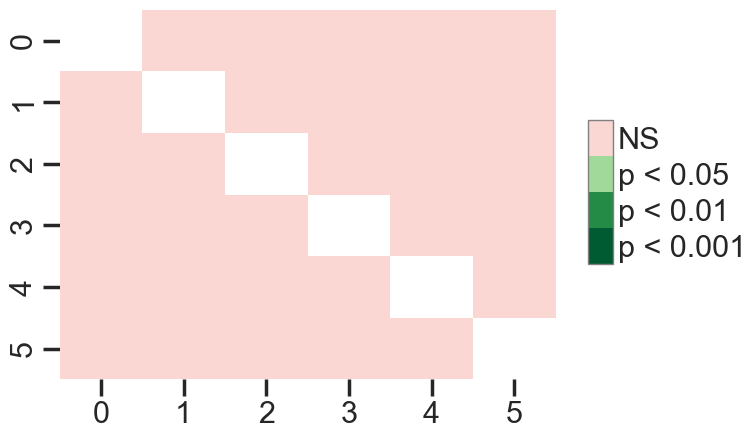

In [30]:
test_results = sp.posthoc_nemenyi_friedman(data)
print(test_results)
sp.sign_plot(test_results)

     0         1         2         3         4    5
0  1.0  1.000000  1.000000  1.000000  1.000000  1.0
1  1.0  1.000000  1.000000  1.000000  0.228667  1.0
2  1.0  1.000000  1.000000  1.000000  0.141225  1.0
3  1.0  1.000000  1.000000  1.000000  0.653986  1.0
4  1.0  0.228667  0.141225  0.653986  1.000000  1.0
5  1.0  1.000000  1.000000  1.000000  1.000000  1.0


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1a3484c8f40>)

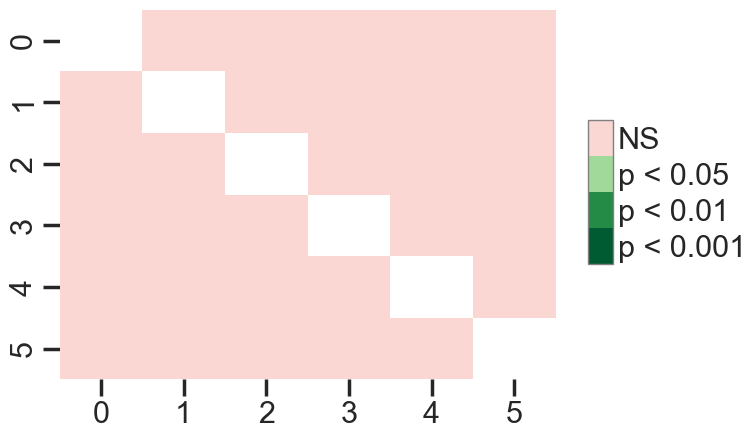

In [31]:
test_results = sp.posthoc_conover_friedman(data, p_adjust='bonferroni')
print(test_results)
sp.sign_plot(test_results)

          0         1         2         3         4         5
0  1.000000  0.998479  0.316275  0.915995  0.843469  1.000000
1  0.998479  1.000000  0.590481  0.991745  0.972894  0.998479
2  0.316275  0.590481  1.000000  0.915995  0.962566  0.316275
3  0.915995  0.991745  0.915995  1.000000  0.999976  0.915995
4  0.843469  0.972894  0.962566  0.999976  1.000000  0.843469
5  1.000000  0.998479  0.316275  0.915995  0.843469  1.000000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x200c602c4f0>)

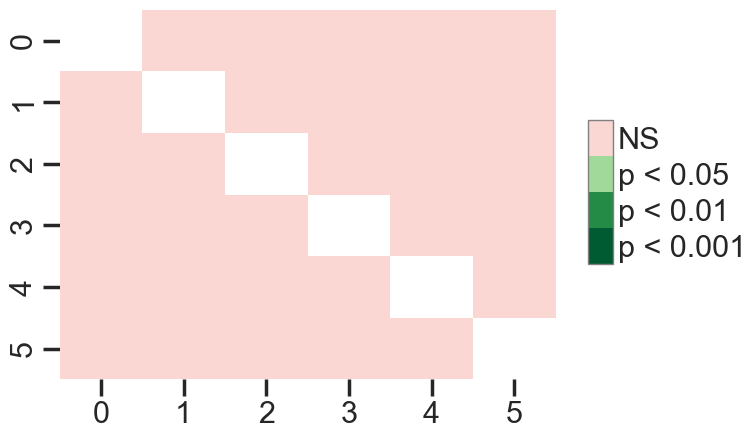

In [15]:
test_results = sp.posthoc_miller_friedman(data)
print(test_results)
sp.sign_plot(test_results)

# TODO -> NIPS! -> ICML
1. Weight decay
2. Tanh
3. FILM (low priority)
4. OGBG
5. Più di 3 split

## Test with N largest
https://stackoverflow.com/questions/45365923/how-to-use-nlargest-on-multilevel-pivot-table-in-pandas

In [11]:
df

Dataset  Pre-process layers  MP layers  Post-process layers   GNN Type   
0         DD                   1          2                    2    GCNconv  \
1         DD                   1          2                    2    GCNconv   
2         DD                   1          2                    2    GCNconv   
3         DD                   1          2                    3    GCNconv   
4         DD                   1          2                    3    GCNconv   
...      ...                 ...        ...                  ...        ...   
2058     PTC                   2          8                    2  GraphConv   
2059     PTC                   2          8                    2  GraphConv   
2060     PTC                   2          8                    3  GraphConv   
2061     PTC                   2          8                    3  GraphConv   
2062     PTC                   2          8                    3  GraphConv   

      Hidden Neurons  Training epochs    loss loss_std       Params   
0                 64              200  0.7405   0.1876     351874.0  \
1                128              105  0.9547   0.3884    1391874.0   
2                256              145   0.691   0.1273    5536258.0   
3                 64               45  0.6901     0.16     684802.0   
4                128               30  0.5709   0.0392    2721282.0   
...              ...              ...     ...      ...          ...   
2058             128               15  0.9411   0.1192   13156226.0   
2059             256               95  3.7388   3.2002   52592386.0   
2060              64              245  1.2183   0.2311    6282562.0   
2061             128              100  0.8196    0.151   25107074.0   
2062             256               95  0.9324   0.1099  100381954.0   

      time_iter  time_iter_std  accuracy  accuracy_std precision   
0        0.0464         0.0103    0.7283        0.0210    0.7442  \
1        0.0411         0.0014    0.6891        0.0238    0.8809   
2        0.0381         0.0031    0.7199        0.0277    0.8053   
3        0.0968         0.0220    0.7451        0.0158    0.8058   
4        0.0692         0.0062    0.7199        0.0286     0.743   
...         ...            ...       ...           ...       ...   
2058     0.0066         0.0002    0.5714        0.0000    0.4432   
2059     0.0113         0.0001    0.5905        0.1197    0.3319   
2060     0.0110         0.0003    0.6191        0.0819    0.4765   
2061     0.0123         0.0013    0.6381        0.0587    0.5503   
2062     0.0065         0.0001    0.5809        0.0135      0.45   

     precision_std  recall recall_std      f1  f1_std     auc auc_std  
0           0.0349  0.6753     0.1192  0.6995  0.0468  0.8057  0.0225  
1           0.0558  0.4152     0.0845  0.5557  0.0675  0.8299  0.0458  
2           0.0702  0.5703     0.1247  0.6543  0.0597  0.8151  0.0234  
3           0.0701   0.639     0.1108  0.7006  0.0505  0.8309  0.0042  
4           0.0509  0.6635      0.157   0.684  0.0758  0.8286  0.0292  
...            ...     ...        ...     ...     ...     ...     ...  
2058        0.1162  0.6341     0.2111  0.5091  0.1197  0.6473  0.0476  
2059        0.2522  0.4538     0.3221  0.3762  0.2711  0.5095  0.1175  
2060        0.0554  0.5433     0.2324  0.4903   0.145  0.6056  0.0748  
2061        0.0973  0.3548     0.1824  0.3939  0.1379  0.6065  0.0444  
2062        0.1472   0.324     0.0282  0.3646  0.0648   0.511  0.0835  

[2015 rows x 22 columns]

In [28]:
test2 = df.sort_values('accuracy', ascending=False).groupby(['Dataset','GNN Type']).head(3)
test2.pivot_table(values=['accuracy', 'accuracy_std','Params'], columns=['Dataset','GNN Type'], index=['Pre-process layers', 'MP layers', 'Post-process layers', 'Hidden Neurons'])

Params   
Dataset                                                                  DD   
GNN Type                                                            GCNconv   
Pre-process layers MP layers Post-process layers Hidden Neurons               
1                  2         2                   64                     NaN  \
                                                 128                    NaN   
                                                 256                    NaN   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                   4         2                   64                     NaN   
                                                 128                    NaN   
                                                 256             15437826.0   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                   6         2                   64                     NaN   
                                                 256                    NaN   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                   8         2                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
2                  2         2                   64                     NaN   
                                                 256                    NaN   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                   4         2                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                   6         2                   64                     NaN   
                                                 128              7607298.0   
                                                 256                    NaN   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   
                   8         2                   64               3149698.0   
                                                 128                    NaN   
                                                 256                    NaN   
                             3                   64                     NaN   
                                                 128                    NaN   
                                                 256                    NaN   

                                                                             
Dataset                                 

In [30]:
test = df.groupby(['Dataset','GNN Type']).nlargest(3, 'accuracy')
test

AttributeError: 'DataFrameGroupBy' object has no attribute 'nlargest'

In [18]:
test.index.get_level_values(None)

Index([  37,   42,    8, 1760, 1727, 1764,  349,  361,  341,  702,
       ...
        567,  874,  896,  901, 1207, 1204, 1223, 1557, 1540, 1582],
      dtype='int64', length=126)

In [19]:
df

Dataset  Pre-process layers  MP layers  Post-process layers   GNN Type   
0         DD                   1          2                    2    GCNconv  \
1         DD                   1          2                    2    GCNconv   
2         DD                   1          2                    2    GCNconv   
3         DD                   1          2                    3    GCNconv   
4         DD                   1          2                    3    GCNconv   
...      ...                 ...        ...                  ...        ...   
2058     PTC                   2          8                    2  GraphConv   
2059     PTC                   2          8                    2  GraphConv   
2060     PTC                   2          8                    3  GraphConv   
2061     PTC                   2          8                    3  GraphConv   
2062     PTC                   2          8                    3  GraphConv   

      Hidden Neurons  Training epochs    loss loss_std       Params   
0                 64              200  0.7405   0.1876     351874.0  \
1                128              105  0.9547   0.3884    1391874.0   
2                256              145   0.691   0.1273    5536258.0   
3                 64               45  0.6901     0.16     684802.0   
4                128               30  0.5709   0.0392    2721282.0   
...              ...              ...     ...      ...          ...   
2058             128               15  0.9411   0.1192   13156226.0   
2059             256               95  3.7388   3.2002   52592386.0   
2060              64              245  1.2183   0.2311    6282562.0   
2061             128              100  0.8196    0.151   25107074.0   
2062             256               95  0.9324   0.1099  100381954.0   

      time_iter  time_iter_std  accuracy  accuracy_std precision   
0        0.0464         0.0103    0.7283        0.0210    0.7442  \
1        0.0411         0.0014    0.6891        0.0238    0.8809   
2        0.0381         0.0031    0.7199        0.0277    0.8053   
3        0.0968         0.0220    0.7451        0.0158    0.8058   
4        0.0692         0.0062    0.7199        0.0286     0.743   
...         ...            ...       ...           ...       ...   
2058     0.0066         0.0002    0.5714        0.0000    0.4432   
2059     0.0113         0.0001    0.5905        0.1197    0.3319   
2060     0.0110         0.0003    0.6191        0.0819    0.4765   
2061     0.0123         0.0013    0.6381        0.0587    0.5503   
2062     0.0065         0.0001    0.5809        0.0135      0.45   

     precision_std  recall recall_std      f1  f1_std     auc auc_std  
0           0.0349  0.6753     0.1192  0.6995  0.0468  0.8057  0.0225  
1           0.0558  0.4152     0.0845  0.5557  0.0675  0.8299  0.0458  
2           0.0702  0.5703     0.1247  0.6543  0.0597  0.8151  0.0234  
3           0.0701   0.639     0.1108  0.7006  0.0505  0.8309  0.0042  
4           0.0509  0.6635      0.157   0.684  0.0758  0.8286  0.0292  
...            ...     ...        ...     ...     ...     ...     ...  
2058        0.1162  0.6341     0.2111  0.5091  0.1197  0.6473  0.0476  
2059        0.2522  0.4538     0.3221  0.3762  0.2711  0.5095  0.1175  
2060        0.0554  0.5433     0.2324  0.4903   0.145  0.6056  0.0748  
2061        0.0973  0.3548     0.1824  0.3939  0.1379  0.6065  0.0444  
2062        0.1472   0.324     0.0282  0.3646  0.0648   0.511  0.0835  

[2015 rows x 22 columns]